In [2]:
import util, scrape

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
tqdm.pandas()

import collections
import itertools
import re
import pickle
import csv
import multiprocessing
import operator
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

import gensim

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [3]:
# load trip reports dataframe
with open(util.TRIP_REPORTS_DATAFRAME_FILE, "rb") as f:
    df = pickle.load(f)
    
df

drug                                        trip_report  \
0                  LSD  During the Summer of 2004 I experienced what I...   
1                  2CD  This is a report about my first time trying 2C...   
2                  AMT  It was the start of Superbowl Weekand, and I w...   
3        Morning_Glory  I’ve always heard how Morning Glory seeds can ...   
4                  2CE  Background: I am male, at the time of this exp...   
...                ...                                                ...   
5592               LSD  To start off I would consider myself a very ex...   
5593  Salvia_divinorum  I was home alone in my little apartment in Lon...   
5594             2CT21  Setting: Alone on a weekday evening. My comfor...   
5595               LSD  It started off as a harmless birthday party. M...   
5596         Mushrooms  My experiance began one month ago.  After a he...   

                                  trip_report_tokenized  
0     [experience, describe, clean, wholesome, drug,...  
1     [report, time, try, old, male, live, center, r...  
2     [start, excited, road, trip, visit, friend, li...  
3     [hear, morning, high, mean, try, time, finally...  
4     [background, male, time, experience, weigh, us...  
...                                                 ...  
5592  [start, consider, experienced, trip, common, p...  
5593  [home, little, apartment, take, delivery, day,...  
5594  [set, comfortable, apartment, rest, non, stres...  
5595  [start, harmless, birthday, party, friend, cat...  
5596  [experiance, begin, hectic, wake, friend, beat...  

[5597 rows x 3 columns]

In [4]:
# label docs individually by enumeration
def label_docs(X):
    labeled = []
    for i, doc in enumerate(X):
        labeled.append(gensim.models.doc2vec.TaggedDocument(words=doc, tags=[f"DOC_{i}"]))
    return labeled


In [5]:
# create mask for dataframe columns to only include:
# (1) top N drugs with the most trip reports 
# (2) trip reports with at least this many tokens to ensure informative content

N = 10
MIN_TOKENS = 30 

mask_1 = [True if len(tokens) > MIN_TOKENS else False for tokens in df["trip_report_tokenized"]]

counter = collections.Counter(df["drug"][mask_1])
top_drugs = sorted(counter, key=lambda x: counter[x], reverse=True)[:N]
mask_2 = [True if df["drug"][i] in top_drugs else False for i, tokens in enumerate(df["trip_report_tokenized"])]

mask = np.logical_and(mask_1, mask_2)


In [6]:
def get_train_test_split_indices(y, train_size=0.8):
    indices = [i for i in range(len(y))]
    train_indices, test_indices, y_train, y_test = train_test_split(indices, y, train_size=train_size, stratify=y)
    
    return train_indices, test_indices
    
def split_X_into_train_test_sets(X, train_indices, test_indices):
    X_train = X[train_indices, :]
    X_test = X[test_indices, :]
        
    return X_train, X_test

def split_y_into_train_test_sets(y, train_indices, test_indices):
    y_train = [y[train_index] for train_index in train_indices]
    y_test = [y[test_index] for test_index in test_indices]
    
    return y_train, y_test
    

In [7]:
y = np.array(df["drug"][mask])
train_indices, test_indices = get_train_test_split_indices(y, train_size=0.8)
y_train, y_test = split_y_into_train_test_sets(y, train_indices, test_indices)


In [8]:
# train doc2vec model by num_epochs
def train_doc2vec_model(model, docs, num_epochs, lr_step, lr_min=0.0, verbose=True):
    for epoch in range(1, num_epochs+1):
        if verbose: print(f"Epoch: {epoch}")
        model.train(docs, total_examples=model.corpus_count, epochs=1)
        model.alpha -= lr_step  # decrease the learning rate
        model.min_alpha = lr_min
        

In [9]:
# test given classifier on test set
def test_classifier(clf, X_test, y_test, labels, top_n=3, show_top_n_accuracy=False, show_confusion_matrix=False):
    y_pred = clf.predict(X_test)
    precision, recall, f_score, support = precision_recall_fscore_support(y_test, y_pred, labels=labels, average=None)
    report = pd.DataFrame({
        "class": labels,
        "precision": precision,
        "recall": recall,
        "f_score": f_score,
        "support": support
    })
    
    if show_top_n_accuracy:
        y_hat = clf.predict_proba(X_test)
        classes = clf.classes_
        y_pred_sorted = []
        y_hat_sorted = []
        num_correct = 0
        for i, probs in enumerate(y_hat):
            probs_sorted, classes_sorted = (list(l) for l in zip(*sorted(zip(probs, classes), key=operator.itemgetter(0), reverse=True)))
            true_class = y_test.iloc[i]
            top_classes = classes_sorted[:top_n]
            top_probs = probs_sorted[:top_n]
            y_pred_sorted.append(classes_sorted)
            y_hat_sorted.append(probs_sorted)
            if true_class in top_classes:
                num_correct += 1
        top_n_acc = num_correct / len(y_pred)
        print(f"Top-{top_n} accuracy: {top_n_acc}")
    
    if show_confusion_matrix:
        cm = confusion_matrix(y_test, y_pred)
        new_cm = []
        for row in cm:
            support = sum(row)
            new_row = row / support
            new_cm.append(new_row)
        cm = new_cm

        df_cm = pd.DataFrame(cm, index=labels, columns=labels)
        plt.figure(figsize=(20,20))
        ax = sns.heatmap(df_cm, annot=False, linewidth=0.05)
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        
    return report


In [10]:
def grid_search_doc2vec_models(vector_sizes, windows, lrs_and_lr_steps, training_session_epochs, num_training_sessions, dm=0):
    # If dm=0, distributed bag of words (PV-DBOW) is used. 
    # If dm=1, ‘distributed memory’ (PV-DM) is used.
    
    num_hyperparam_configs = len(vector_sizes)*len(windows)*len(lrs_and_lr_steps)*num_training_sessions
    num_hyperparam_configs_tried = 0

    docs = label_docs(df["trip_report_tokenized"][mask])

    best_f_score_avg = 0.0
    best_model = None
    best_hyperparams = None
    best_report = None
    for vector_size, window, (lr, lr_step) in itertools.product(vector_sizes, windows, lrs_and_lr_steps):
        model = gensim.models.doc2vec.Doc2Vec(docs, workers=multiprocessing.cpu_count(), dm=dm, vector_size=vector_size, window=window, alpha=lr, dm_concat=1)
        epochs_trained = 0
        for i in range(num_training_sessions):
            train_doc2vec_model(model, docs, training_session_epochs, lr_step, verbose=False)
            epochs_trained += training_session_epochs

            # split X into train and test sets using established indices
            X = np.array([model.docvecs[i] for i in range(len(model.docvecs))])
            X_train, X_test = split_X_into_train_test_sets(X, train_indices, test_indices)

            # train a simple Gaussian naive Bayes classifier whose test set predictions' average f_score 
            # will be the measure for a given doc2vec model's quality
            clf = GaussianNB()
            clf.fit(X_train, y_train)

            # test classifier 
            labels = np.unique(y_train)
            report = test_classifier(clf, X_test, y_test, labels)
            f_score_avg = np.mean(report["f_score"])

            # print progress
            num_hyperparam_configs_tried += 1
            print(f"{num_hyperparam_configs_tried} / {num_hyperparam_configs} hyperparameter configurations tested: ({epochs_trained}, {vector_size}, {window}, {lr}, {lr_step})")

            # save best model
            if f_score_avg >= best_f_score_avg:
                best_f_score_avg = f_score_avg
                best_model = copy.deepcopy(model)
                best_hyperparams = (epochs_trained, vector_size, window, lr, lr_step)
                best_report = report
                print(f"New best f-score average: {f_score_avg}")

    print("\nDone")

    model = best_model
    f_score_avg = best_f_score_avg
    report = best_report
    epochs_trained, vector_size, window, lr, lr_step = best_hyperparams
    
    hyperparams = {
        "epochs_trained": epochs_trained,
        "vector_size": vector_size,
        "window": window,
        "lr": lr,
        "lr_step": lr_step
    }

    # print results
    print(f"\nBest model: ")
    print(f"\tF-score average: {f_score_avg}")
    if dm == 0:
        print("\tType of model: PV-DBOW")
    elif dm == 1:
        print("\tType of model: PV-DM")
    print(f"\tEpochs trained: {epochs_trained}")
    print(f"\tVector size: {vector_size}")
    print(f"\tWindow size: {window}")
    print(f"\tLearning rate: {lr}")
    print(f"\tLearning rate step decrease: {lr_step}")
    print(f"\tAverage F-score: {best_f_score_avg}")
    print("\tClassification report:\n")
    print(best_report)
    print("")
    
    return model, f_score_avg, report, hyperparams


In [11]:
vector_sizes = [50, 75, 100, 125, 150] 
windows = [3, 5, 7, 9] 
lrs_and_lr_steps = [
    (2.0e-1, 0.0),
    (2.0e-1, 2.0e-3),
    (1.0e-1, 0.0),
    (1.0e-1, 1.0e-3),
    (7.5e-2, 0.0),
    (7.5e-2, 7.5e-4),
    (5.0e-2, 0.0),
    (5.0e-2, 5.0e-4),
    (2.5e-2, 0.0),
    (2.5e-2, 2.5e-4),
]

training_session_epochs = 5
num_training_sessions = 5


In [ ]:
# Find best PV-DBOW model 
model_dbow, f_score_avg_dbow, report_dbow, hyperparams_dbow = grid_search_doc2vec_models(vector_sizes, windows, lrs_and_lr_steps, training_session_epochs, num_training_sessions, dm=0)
    
# save PV-DM model
with open(util.DOC2VEC_MODEL_DBOW_FILE, "wb") as f:
    pickle.dump(model_dbow, f)
    
# save PV-DBOW hyperparameters
with open(util.DOC2VEC_HYPERPARAMETERS_DBOW_FILE, "wb") as f:
    pickle.dump(hyperparams_dbow, f)


In [ ]:
# Find best PV-DM model 
model_dm, f_score_avg_dm, report_dm, epochs_trained_dm, vector_size_dm, window_dm, lr_dm, lr_step_dm = grid_search_doc2vec_models(vector_sizes, windows, lrs_and_lr_steps, training_session_epochs, num_training_sessions, dm=1)

# save PV-DM model
with open(util.DOC2VEC_MODEL_DM_FILE, "wb") as f:
    pickle.dump(model_dm, f)
    
# save PV-DM hyperparameters
with open(util.DOC2VEC_HYPERPARAMETERS_DM_FILE, "wb") as f:
    pickle.dump(hyperparams_dm, f)


In [ ]:
# use the better of the two models (PV-DBOW and PV-DM) to run grid search on classifiers
model = None
if f_score_avg_dbow > f_score_avg_dm:
    model = model_dbow
    print("Best model type: PV-DBOW")
else:
    model = model_dm
    print("Best model type: PV-DM")
    

In [12]:
model = None
with open(util.DOC2VEC_MODEL_DBOW_FILE, "rb") as f:
    model = pickle.load(f)
    

In [13]:
# run grid search on classifiers and their possible parameters and then return the best result
def grid_search_classifiers(X_train, X_test, y_train, y_test, clfs, clf_to_gs_params_dict, cv=5):
    reports = []
    f_score_avgs = []
    gs_list = []
    for clf in clfs:
        print(f"\tTraining classifier: {clf.__class__}...")
        gs = GridSearchCV(clf, clf_to_gs_params_dict[clf.__class__], cv=cv)
        gs.fit(X_train, y_train)
        gs_list.append(gs)
        labels = np.unique(y_train)
        report = test_classifier(gs, X_test, y_test, labels)
        reports.append(report)
        f_score_avg = np.mean(report["f_score"])
        f_score_avgs.append(f_score_avg)
        
    results_sorted = sorted(zip(gs_list, f_score_avgs, reports), key=lambda x: x[1], reverse=True)
    best_result = results_sorted[0]
            
    return best_result


In [22]:
clfs = [
    GaussianNB(),
    LogisticRegression(),
    KNeighborsClassifier(),
    MLPClassifier()
]

clf_to_gs_params_dict = {
    GaussianNB().__class__: {
    },
    LogisticRegression().__class__: {
        "penalty": ("l1", "l2"),
        "C": (1.0e0, 1.0e-1, 1.0e-2, 1.0e-3, 1.0e-4, 1.0e-5)
    },
    KNeighborsClassifier().__class__: {
        "n_neighbors": (4, 8, 12, 16)
    },
    MLPClassifier().__class__: {
        "hidden_layer_sizes": ((100, 50, 20),),
        "activation": ("relu",),
        "alpha": (1.0e-2,),
        "batch_size": (8,),
        "learning_rate": ("adaptive",),
        "learning_rate_init": (1.0e-3,),
        "early_stopping": (True,),
        "momentum": (0.5,)
    }
}

"""
"hidden_layer_sizes": ((100,), (100, 50), (100, 50, 20)),
"activation": ("relu",),
"alpha": (1.0e-1, 1.0e-2, 1.0e-3),
"batch_size": (8, 16, 64),
"learning_rate": ("constant", "adaptive"),
"learning_rate_init": (1.0e-2, 1.0e-3, 1.0e-4),
"early_stopping": (True,),
"momentum": (0.5, 0.9)
"""

# split X into train and test sets using established indices
X = np.array([model.docvecs[i] for i in range(len(model.docvecs))])
X_train, X_test = split_X_into_train_test_sets(X, train_indices, test_indices)

best_gs, best_f_score_avg, best_report = grid_search_classifiers(X_train, X_test, y_train, y_test, clfs, clf_to_gs_params_dict)
print(f"\tBest classifier: {best_gs.best_estimator_}")
print(f"\tAverage F-score: {best_f_score_avg}")
print(f"\tBest hyperparameters: {best_gs.best_params_}")
print("\tClassification report:\n")
print(best_report)
print("")


	Training classifier: <class 'sklearn.naive_bayes.GaussianNB'>...
	Training classifier: <class 'sklearn.linear_model.logistic.LogisticRegression'>...
	Training classifier: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>...
	Training classifier: <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>...
	Best classifier: GaussianNB(priors=None, var_smoothing=1e-09)
	Average F-score: 0.4300478737674598
	Best hyperparameters: {}
	Classification report:

                       class  precision    recall   f_score  support
0                        2CB   0.181818  0.137931  0.156863       29
1                        2CE   0.272727  0.187500  0.222222       32
2                        2CI   0.333333  0.400000  0.363636       40
3                    5MeODMT   0.307692  0.296296  0.301887       27
4  Cacti_Mescalinecontaining   0.527778  0.431818  0.475000       44
5                        DMT   0.484536  0.661972  0.559524       71
6                        LSD   0.

In [27]:
# train and test using all data with k-fold
def train_and_test_classifier_k_fold(X, y, classifier_name, hyperparams, k_fold=10):
    reports = []
    skf = StratifiedKFold(n_splits=k_fold)
    train_test_split_indices = skf.split(X, y)
        
    for i, (train_indices, test_indices) in enumerate(train_test_split_indices):

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        if len(hyperparams) > 0:
            clf = globals()[classifier_name](hyperparams)
        else:
            clf = globals()[classifier_name]()
        
        clf.fit(X_train, y_train)
        
        labels = np.unique(y_train)
        report = test_classifier(clf, X_test, y_test, labels)
        reports.append(report)
        
    return reports


In [28]:
reports = train_and_test_classifier_k_fold(X, y, classifier_name=best_gs.best_estimator_.__class__.__name__, hyperparams=best_gs.best_params_, k_fold=10)
print(reports)


[                       class  precision    recall   f_score  support
0                        2CB   0.200000  0.333333  0.250000       15
1                        2CE   0.111111  0.058824  0.076923       17
2                        2CI   0.107143  0.150000  0.125000       20
3                    5MeODMT   0.304348  0.500000  0.378378       14
4  Cacti_Mescalinecontaining   0.461538  0.272727  0.342857       22
5                        DMT   0.500000  0.583333  0.538462       36
6                        LSD   0.390805  0.478873  0.430380       71
7              Morning_Glory   0.714286  0.600000  0.652174       25
8                  Mushrooms   0.557895  0.524752  0.540816      101
9           Salvia_divinorum   0.842857  0.641304  0.728395       92,                        class  precision    recall   f_score  support
0                        2CB   0.230769  0.200000  0.214286       15
1                        2CE   0.125000  0.062500  0.083333       16
2                        2CI   0

In [14]:
drugs = sorted(np.unique(y))


In [15]:
# Fit the model using t-SNE randomized algorithm
X_projected = TSNE(metric='cosine', random_state=0).fit_transform(model.docvecs.vectors_docs)


In [21]:
def scatter(X, drugs_to_plot=drugs):
    # make a custom color palette with seaborn
    gray_palette = [[0.8, 0.8, 0.8]]
    color_palette = sns.color_palette("hls", len(drugs_to_plot))
    palette = np.array(color_palette + gray_palette)
    sns.palplot(palette)
    
    # get colors for selected classes
    drug_to_rank_dict = {drug: i for i, drug in enumerate(drugs_to_plot)}
    color_indices = np.array([np.int(drug_to_rank_dict[drug]) if drug in drugs_to_plot else -1 for drug in y])
    color_index_to_drug_dict = {i: drug for i, drug in enumerate(drugs_to_plot)}

    # We create a scatter plot.
    f = plt.figure(figsize=(32, 32))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=120,
                    c=palette[color_indices])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each cluster.
    
    txts = []
    for i, drug in enumerate(drugs_to_plot):
        # Position of each label.
        xtext, ytext = np.median(X[color_indices == i, :], axis=0)
        txt = ax.text(xtext, ytext, color_index_to_drug_dict[i], fontsize=20)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    
    return f, ax, sc, txts


(<Figure size 2304x2304 with 1 Axes>,
 [Text(-18.695152, 14.90722, '2CB'),
  Text(-6.478002, 13.908838, '2CE'),
  Text(-11.374443, 16.855263, '2CI'),
  Text(-5.950732, -9.752149, '5MeODMT'),
  Text(-18.159964, 21.866064, 'Cacti_Mescalinecontaining'),
  Text(-10.352507, -14.053688, 'DMT'),
  Text(10.926434, 7.6692147, 'LSD'),
  Text(-5.8226986, 28.54612, 'Morning_Glory'),
  Text(9.801239, 5.7235174, 'Mushrooms'),
  Text(4.0992074, -16.061222, 'Salvia_divinorum')])

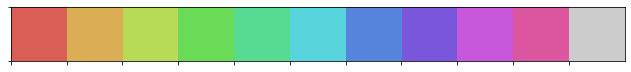

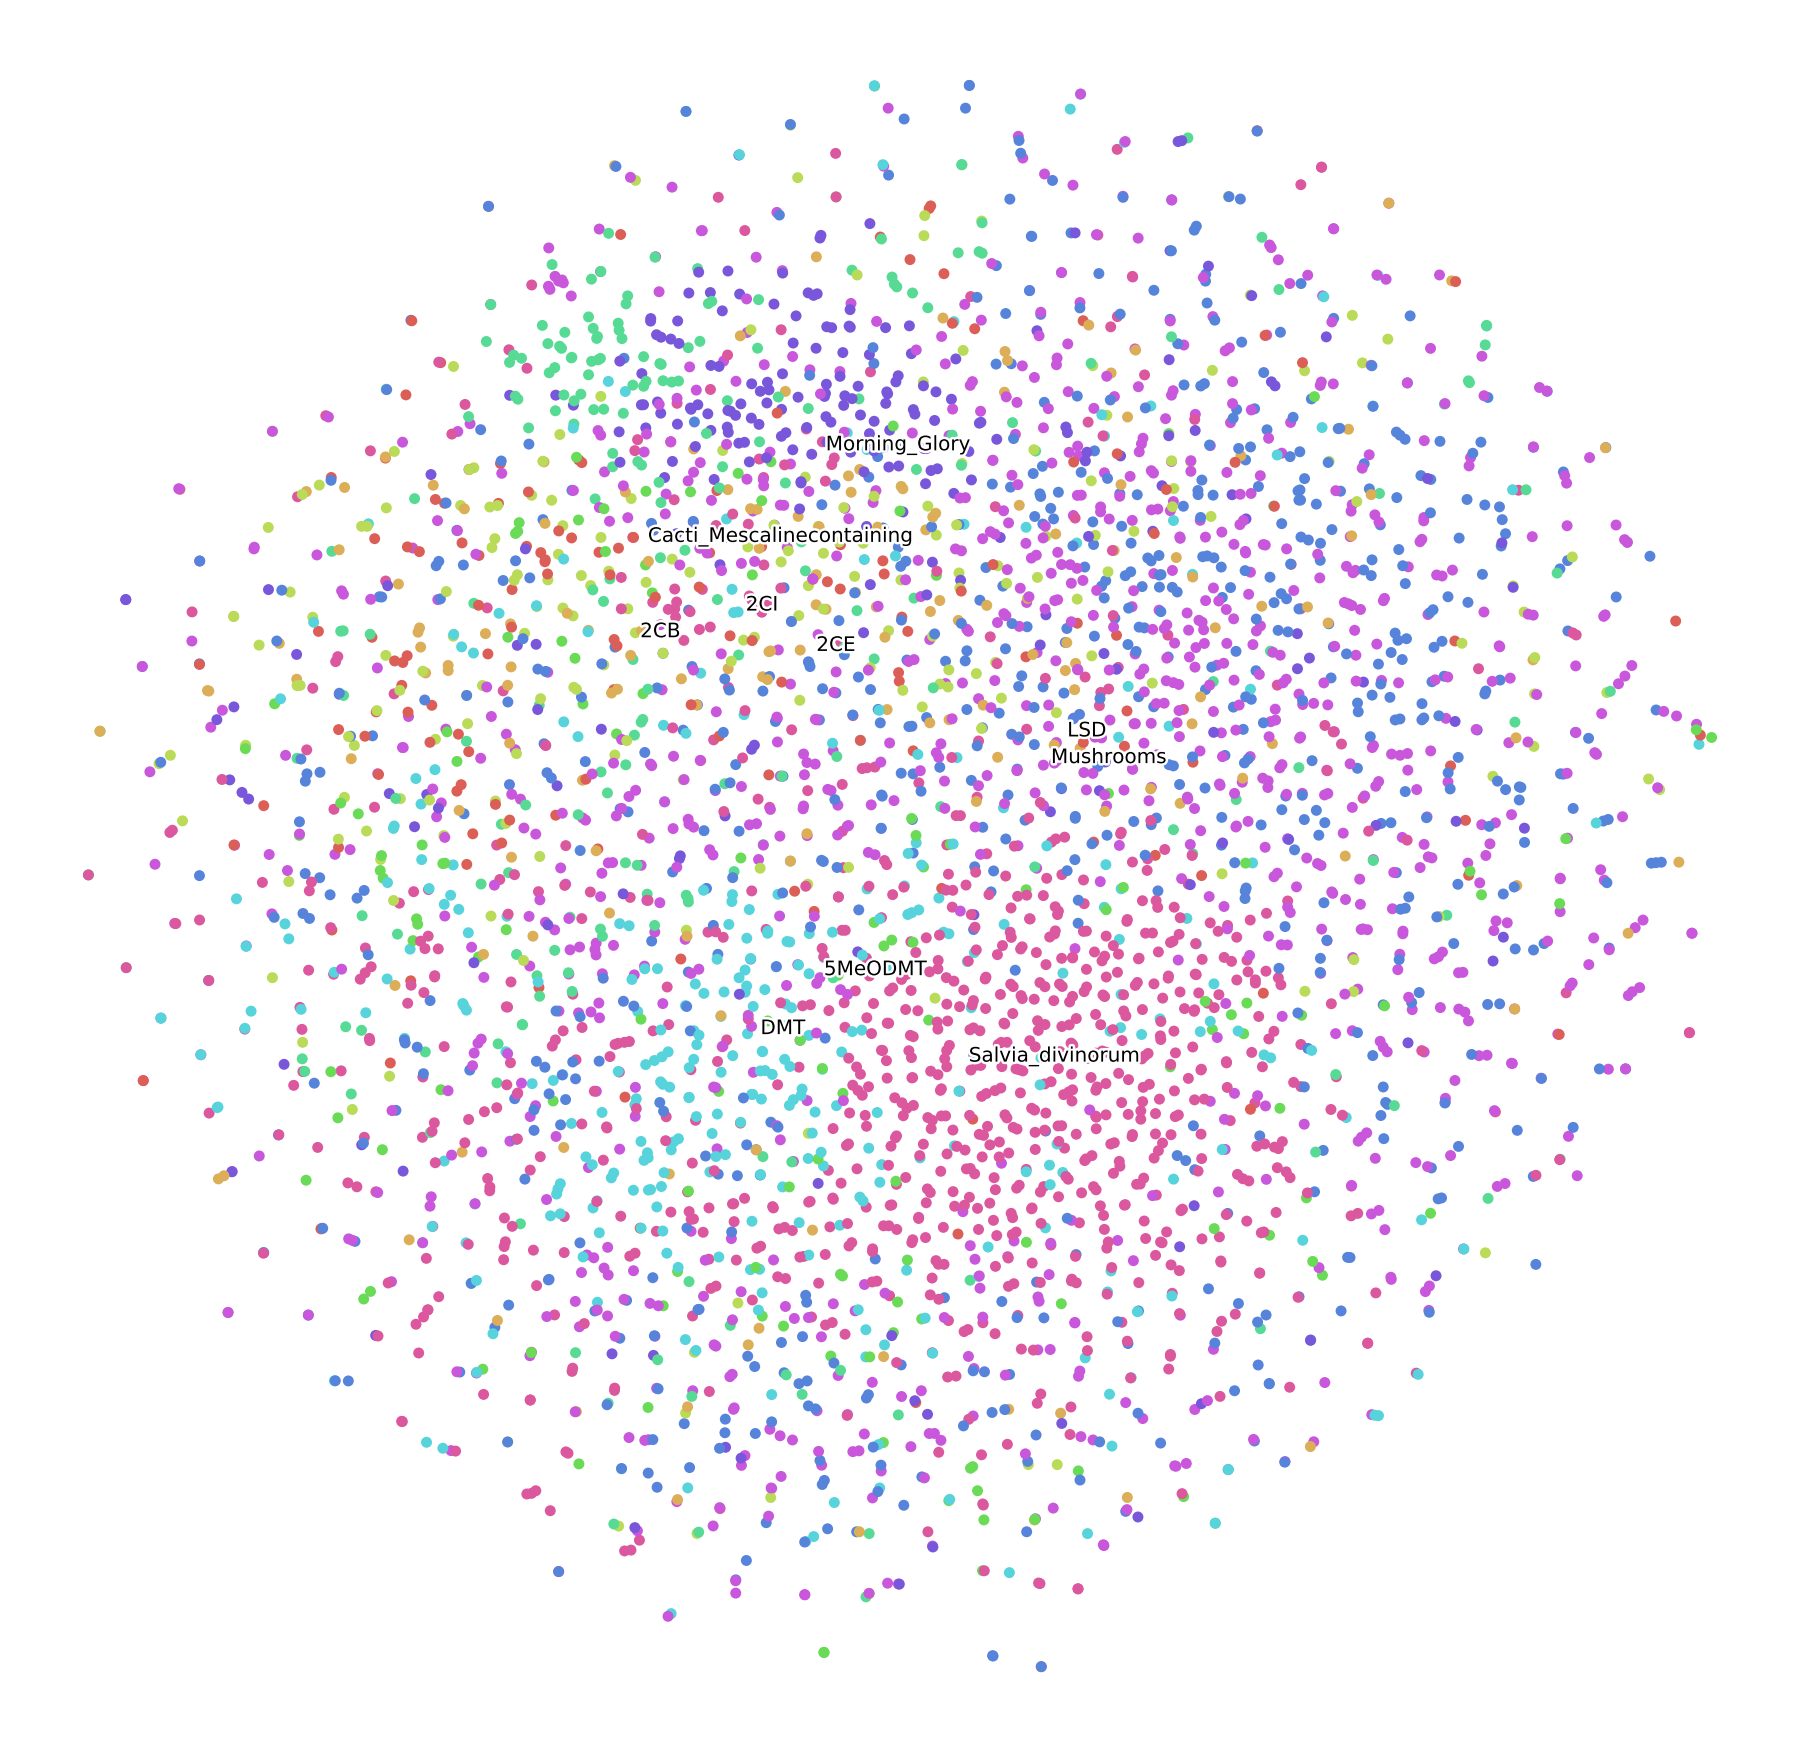

In [22]:
scatter(X_projected)


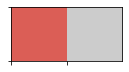

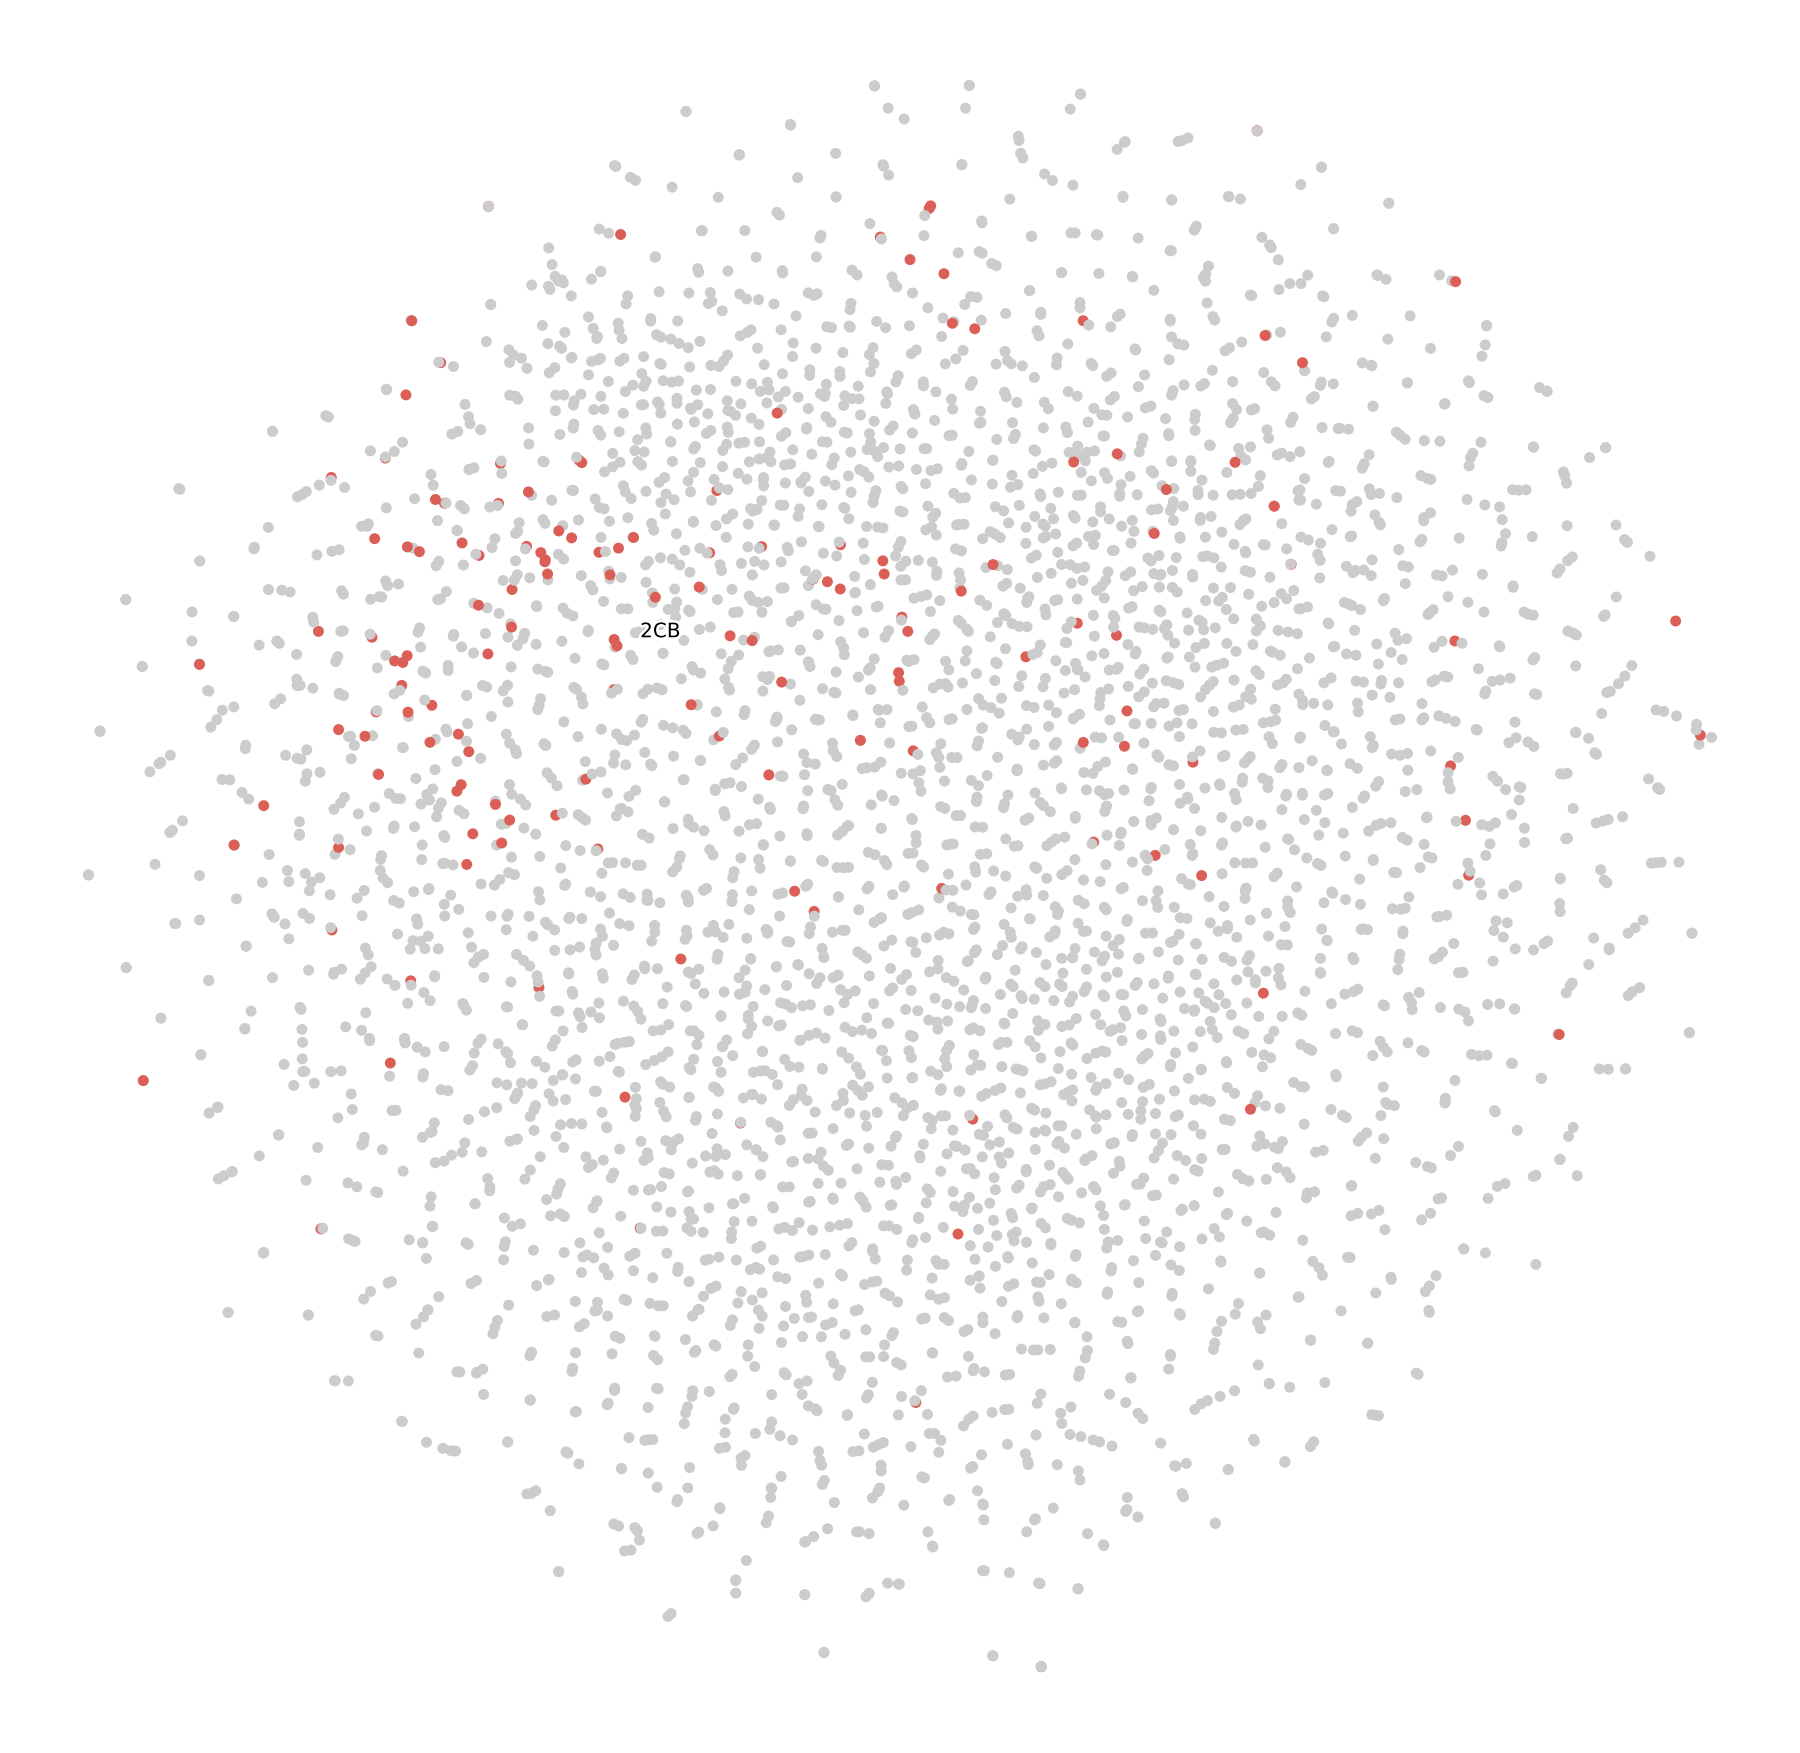

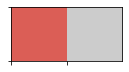

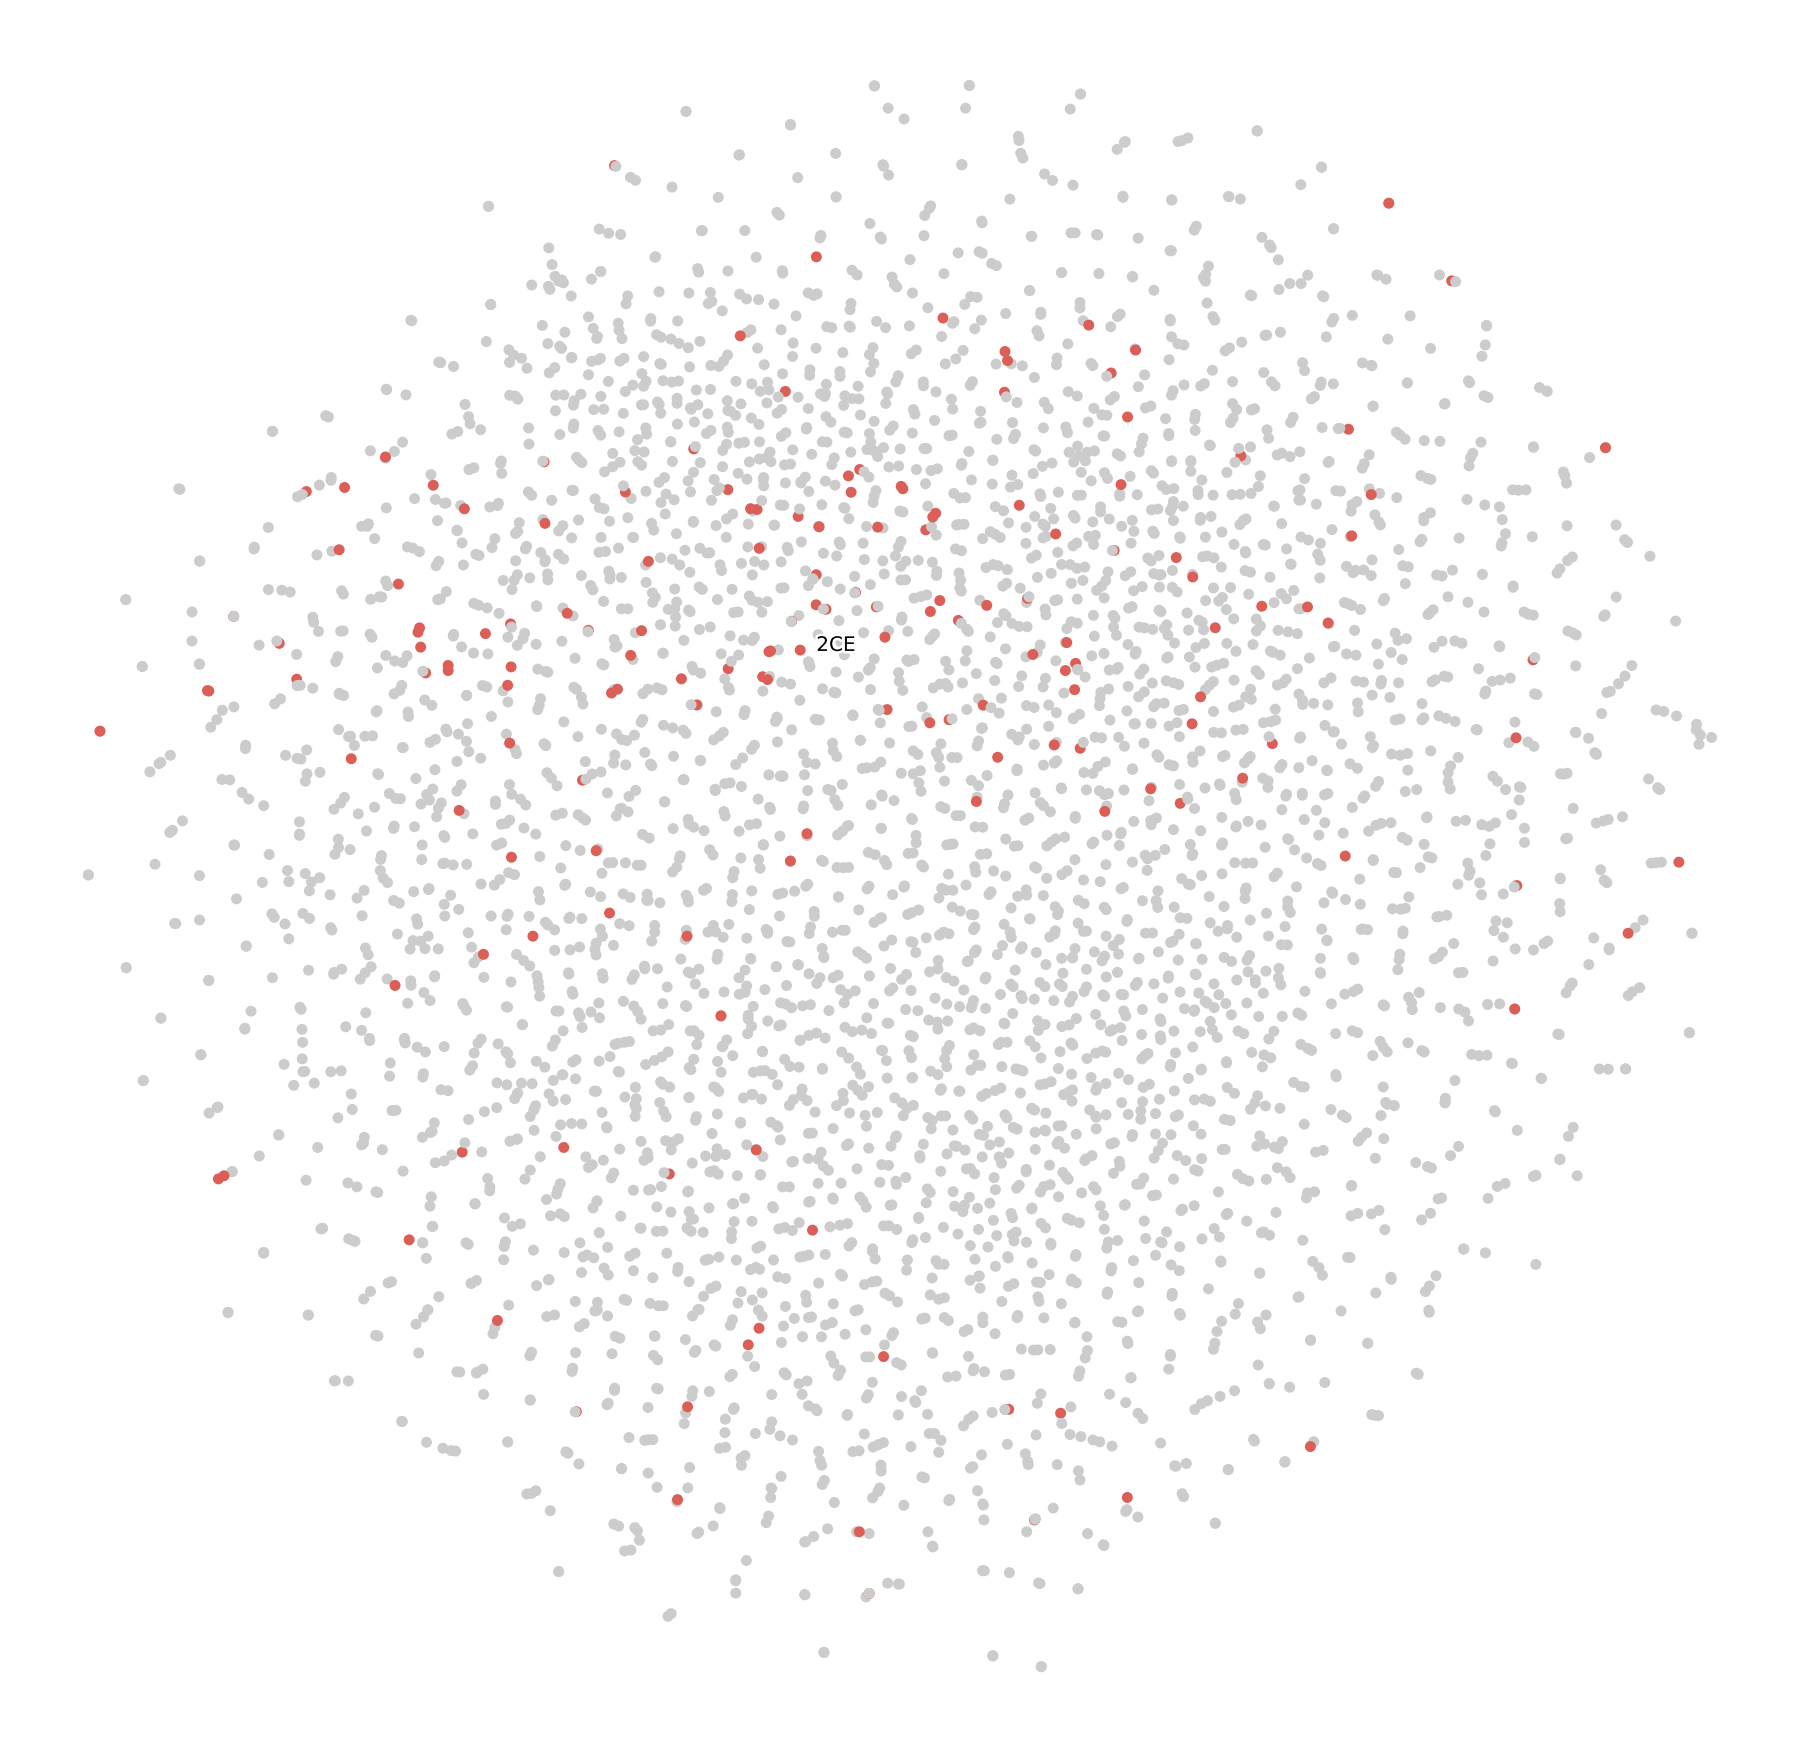

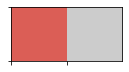

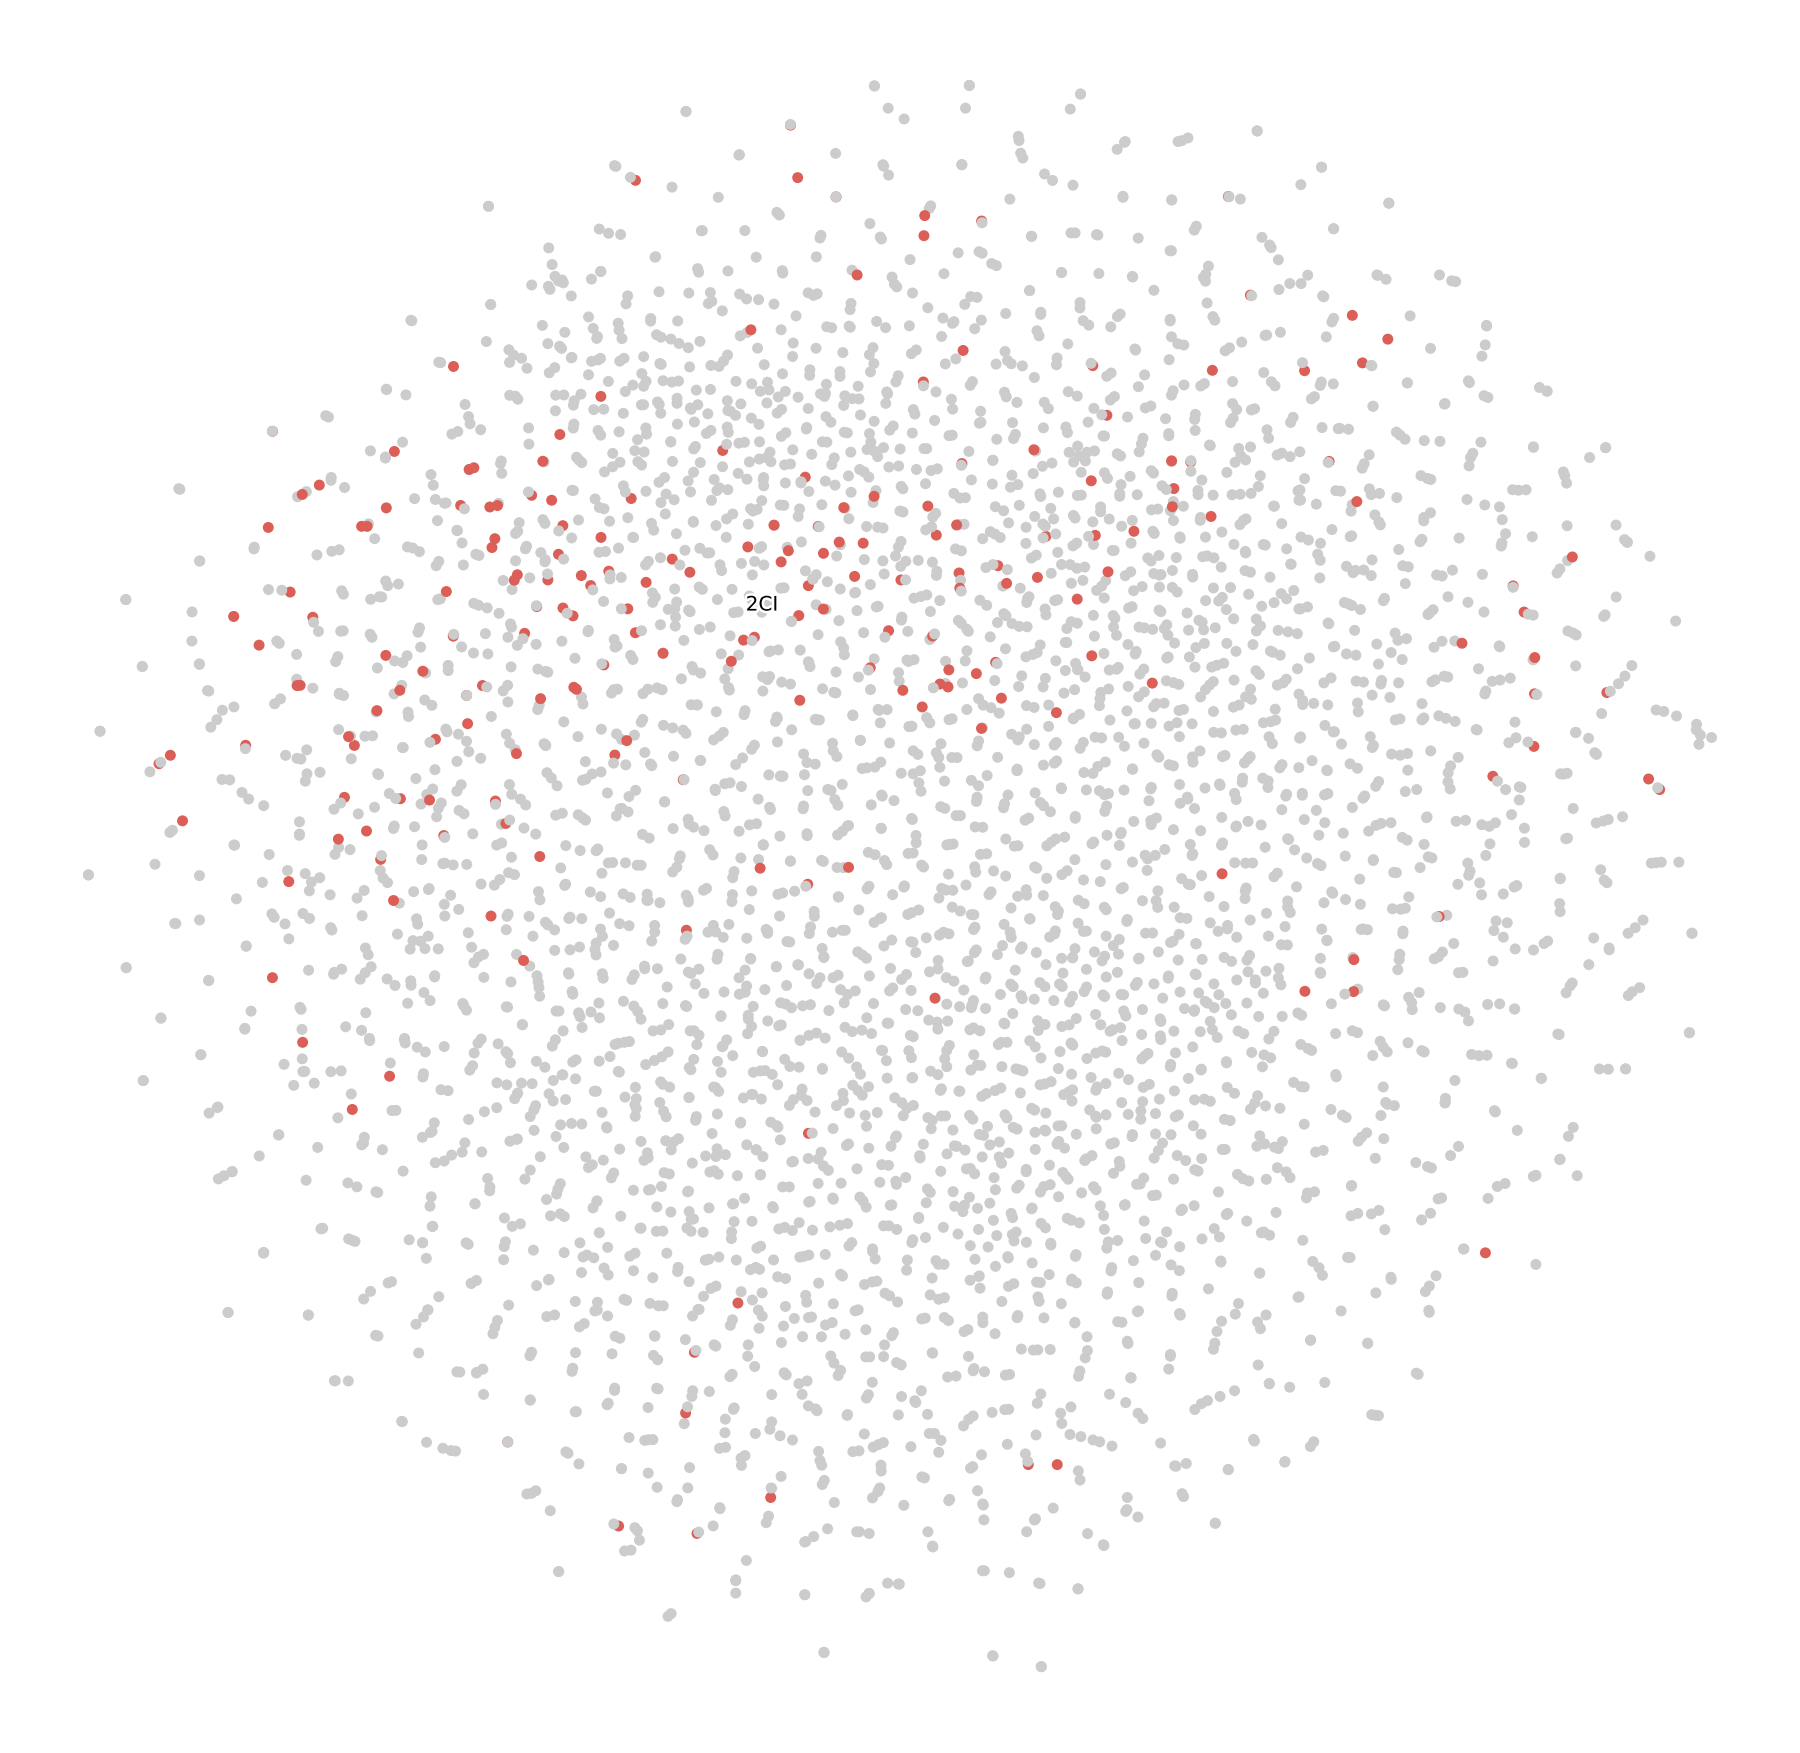

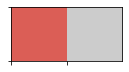

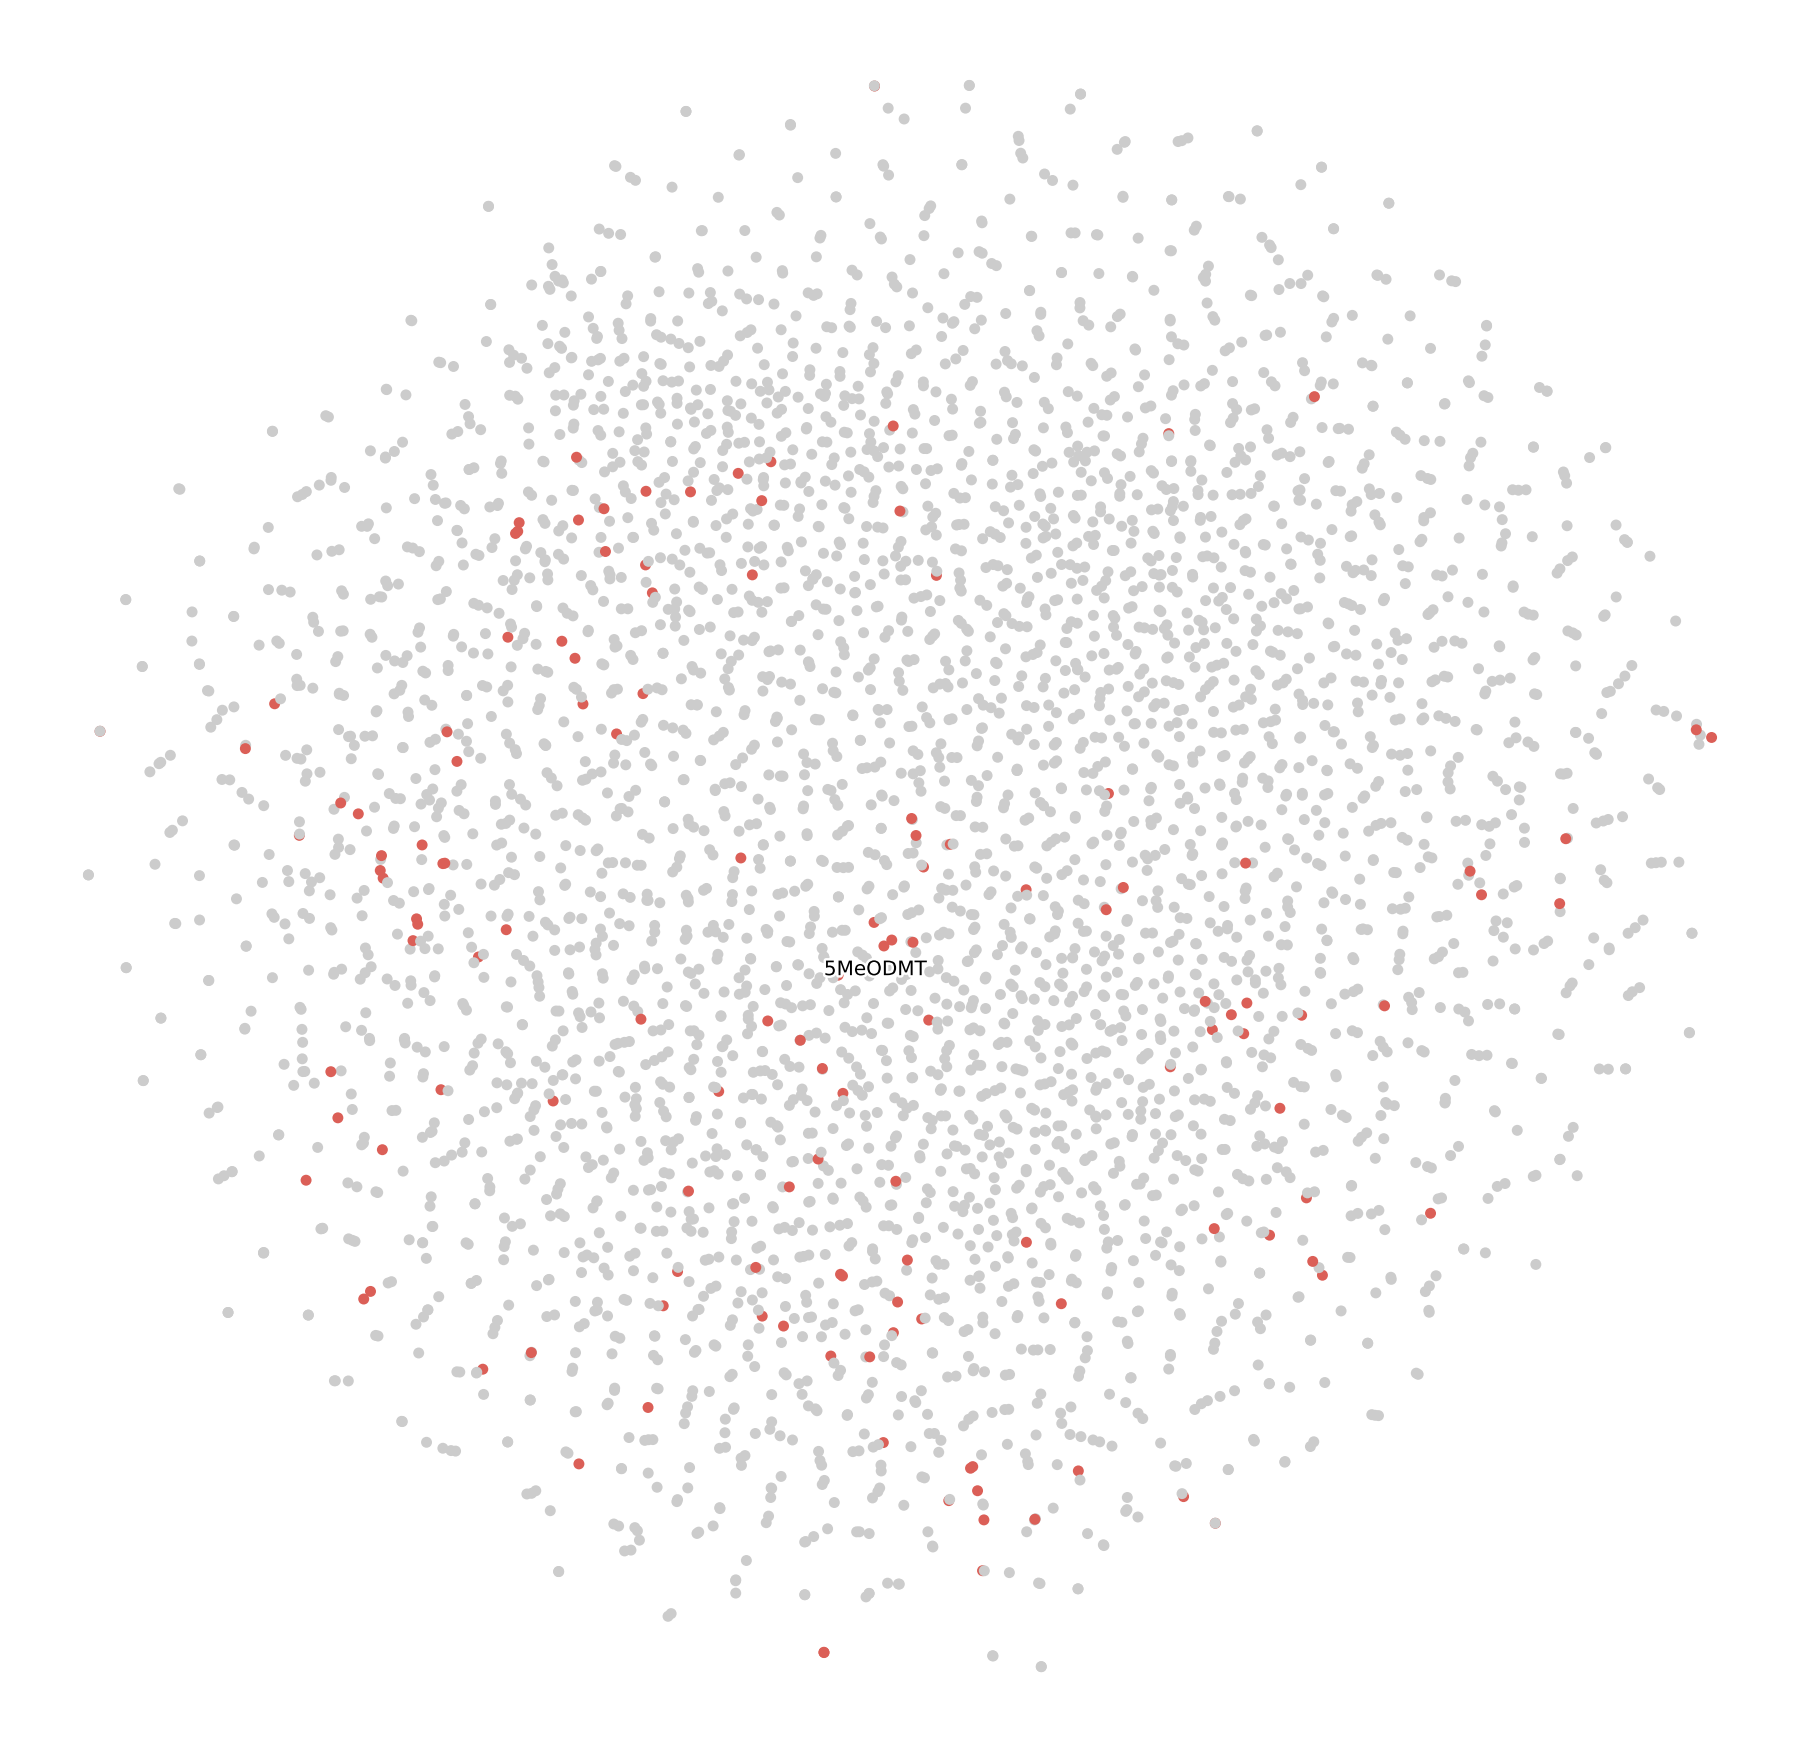

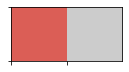

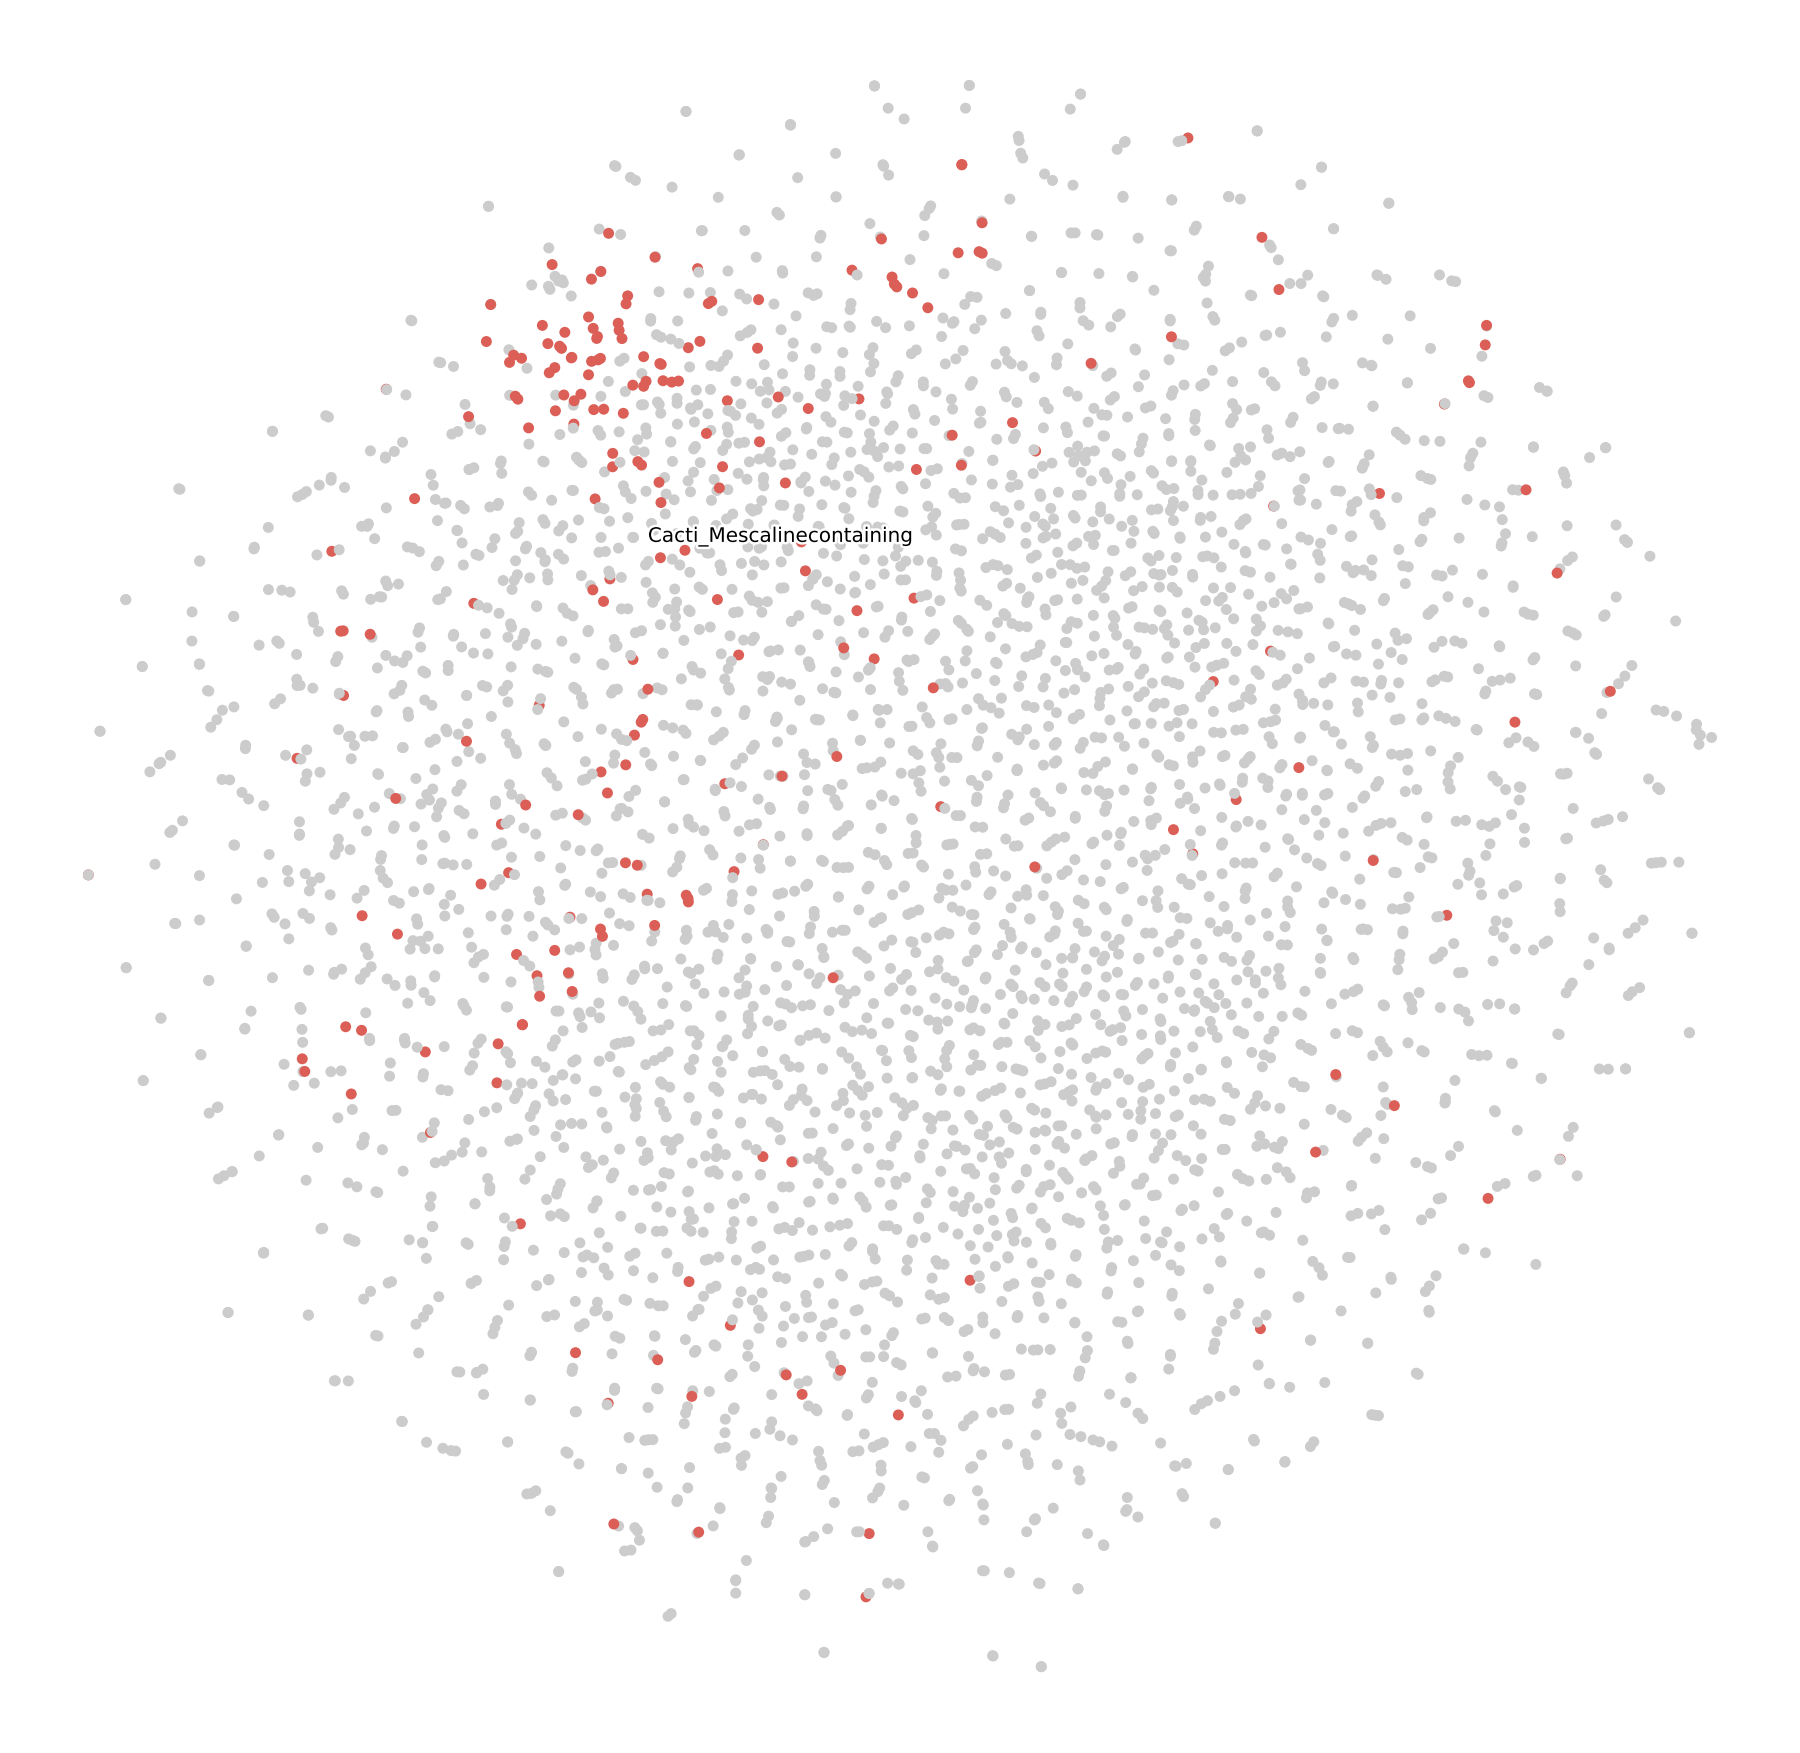

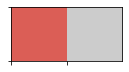

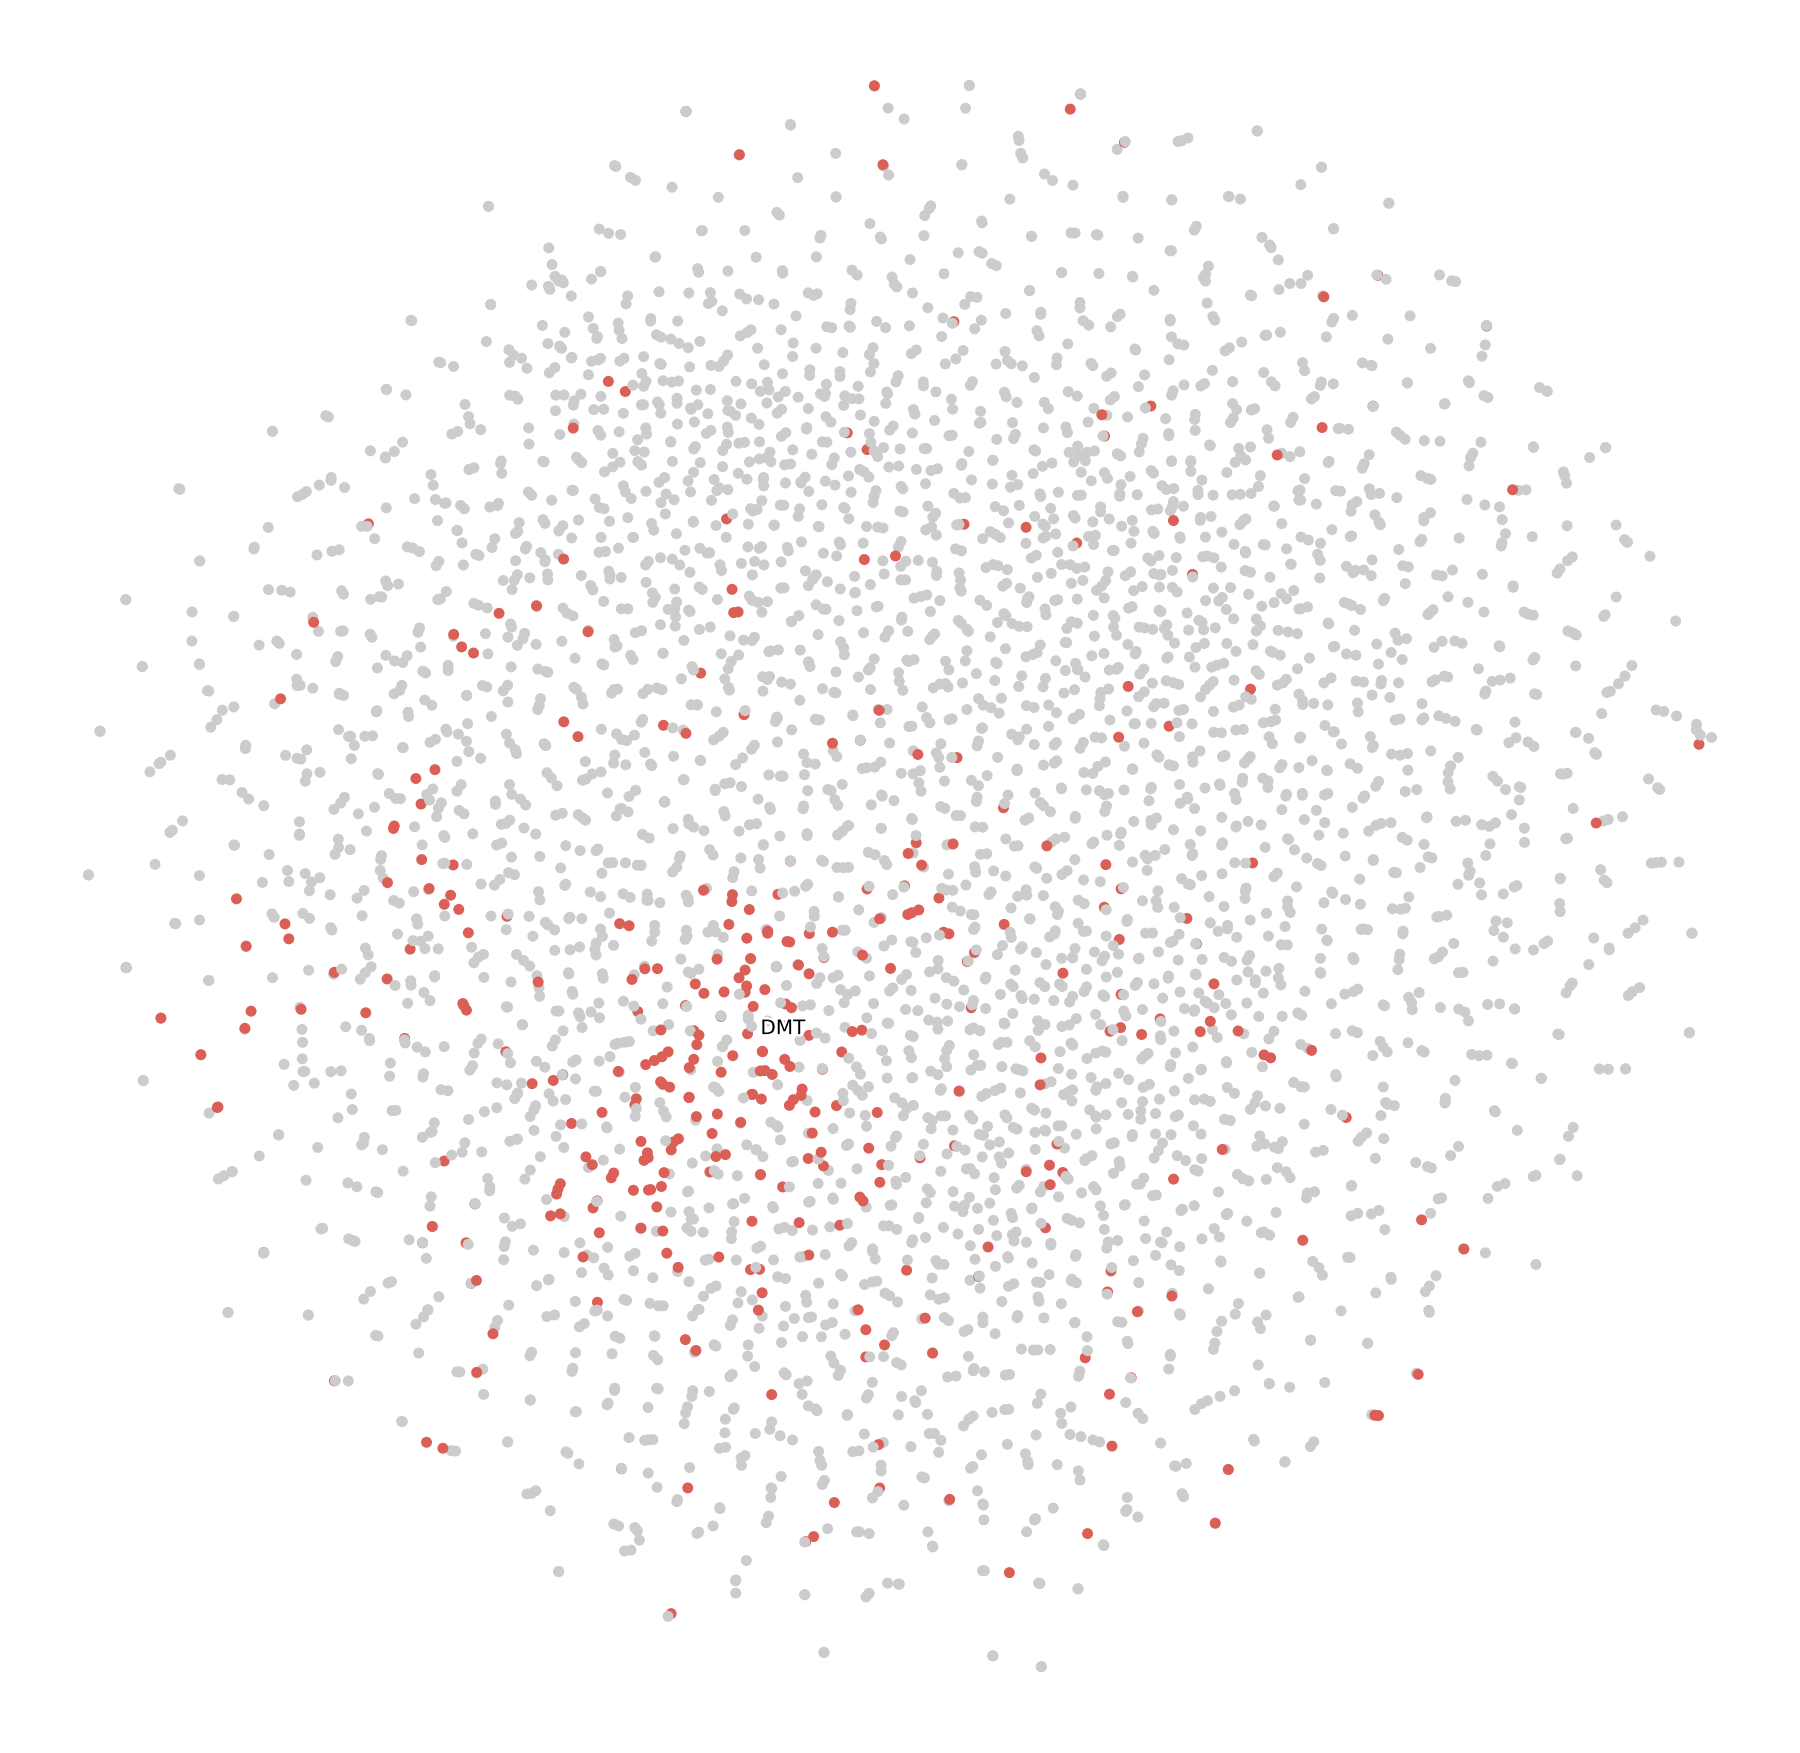

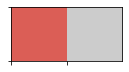

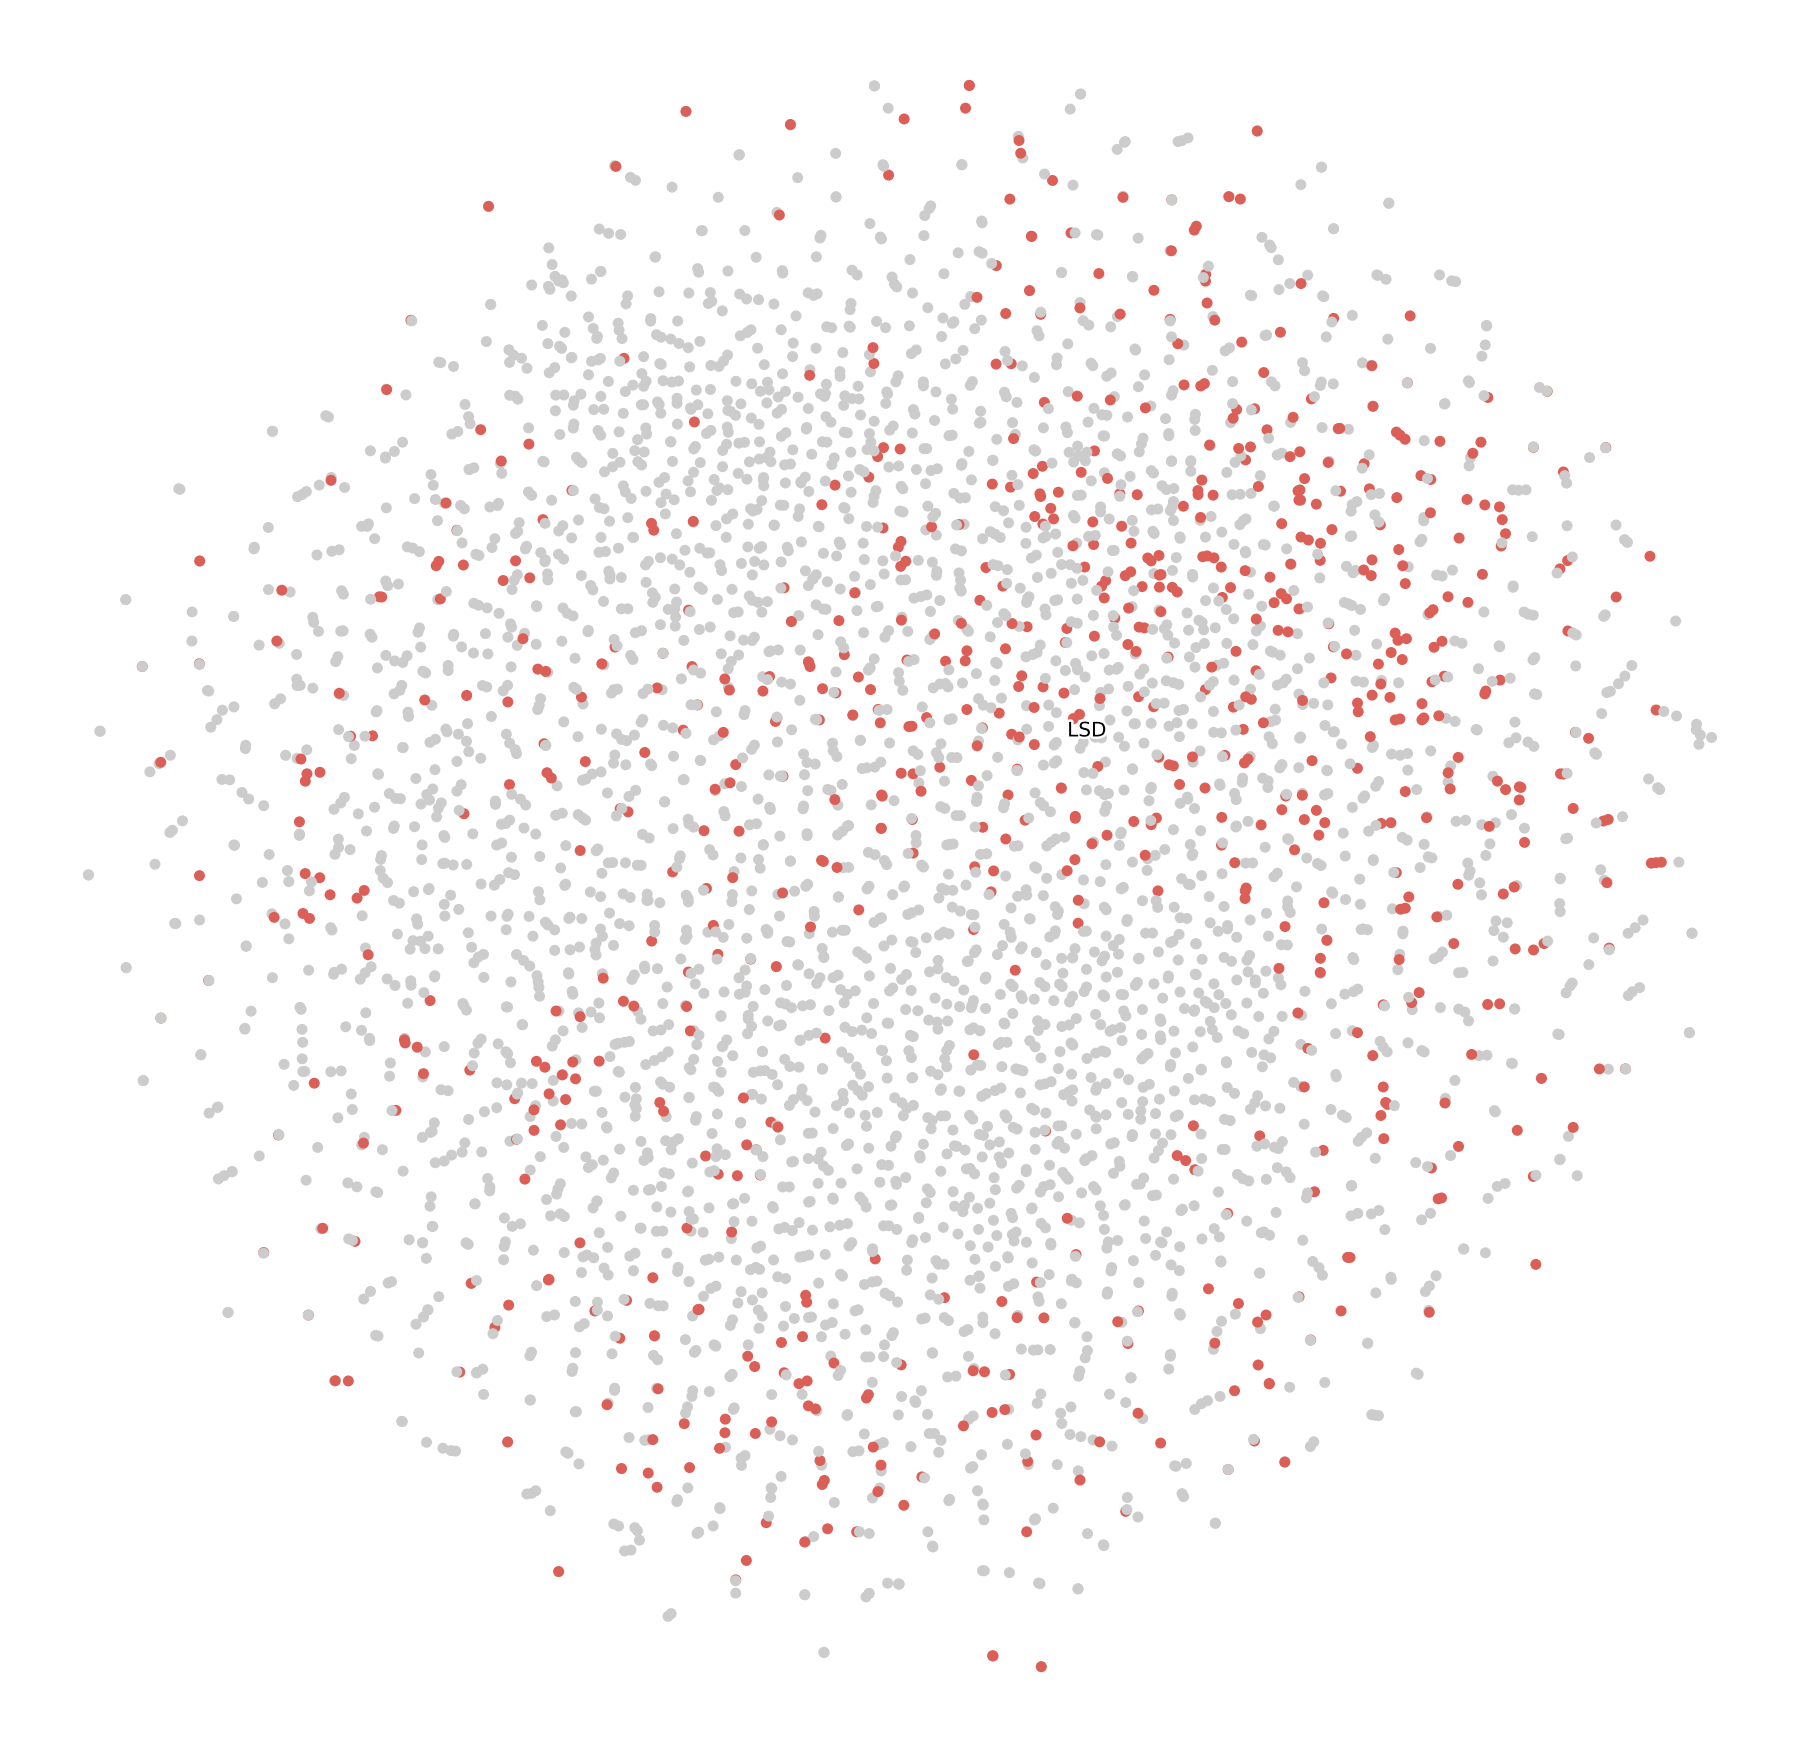

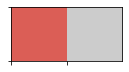

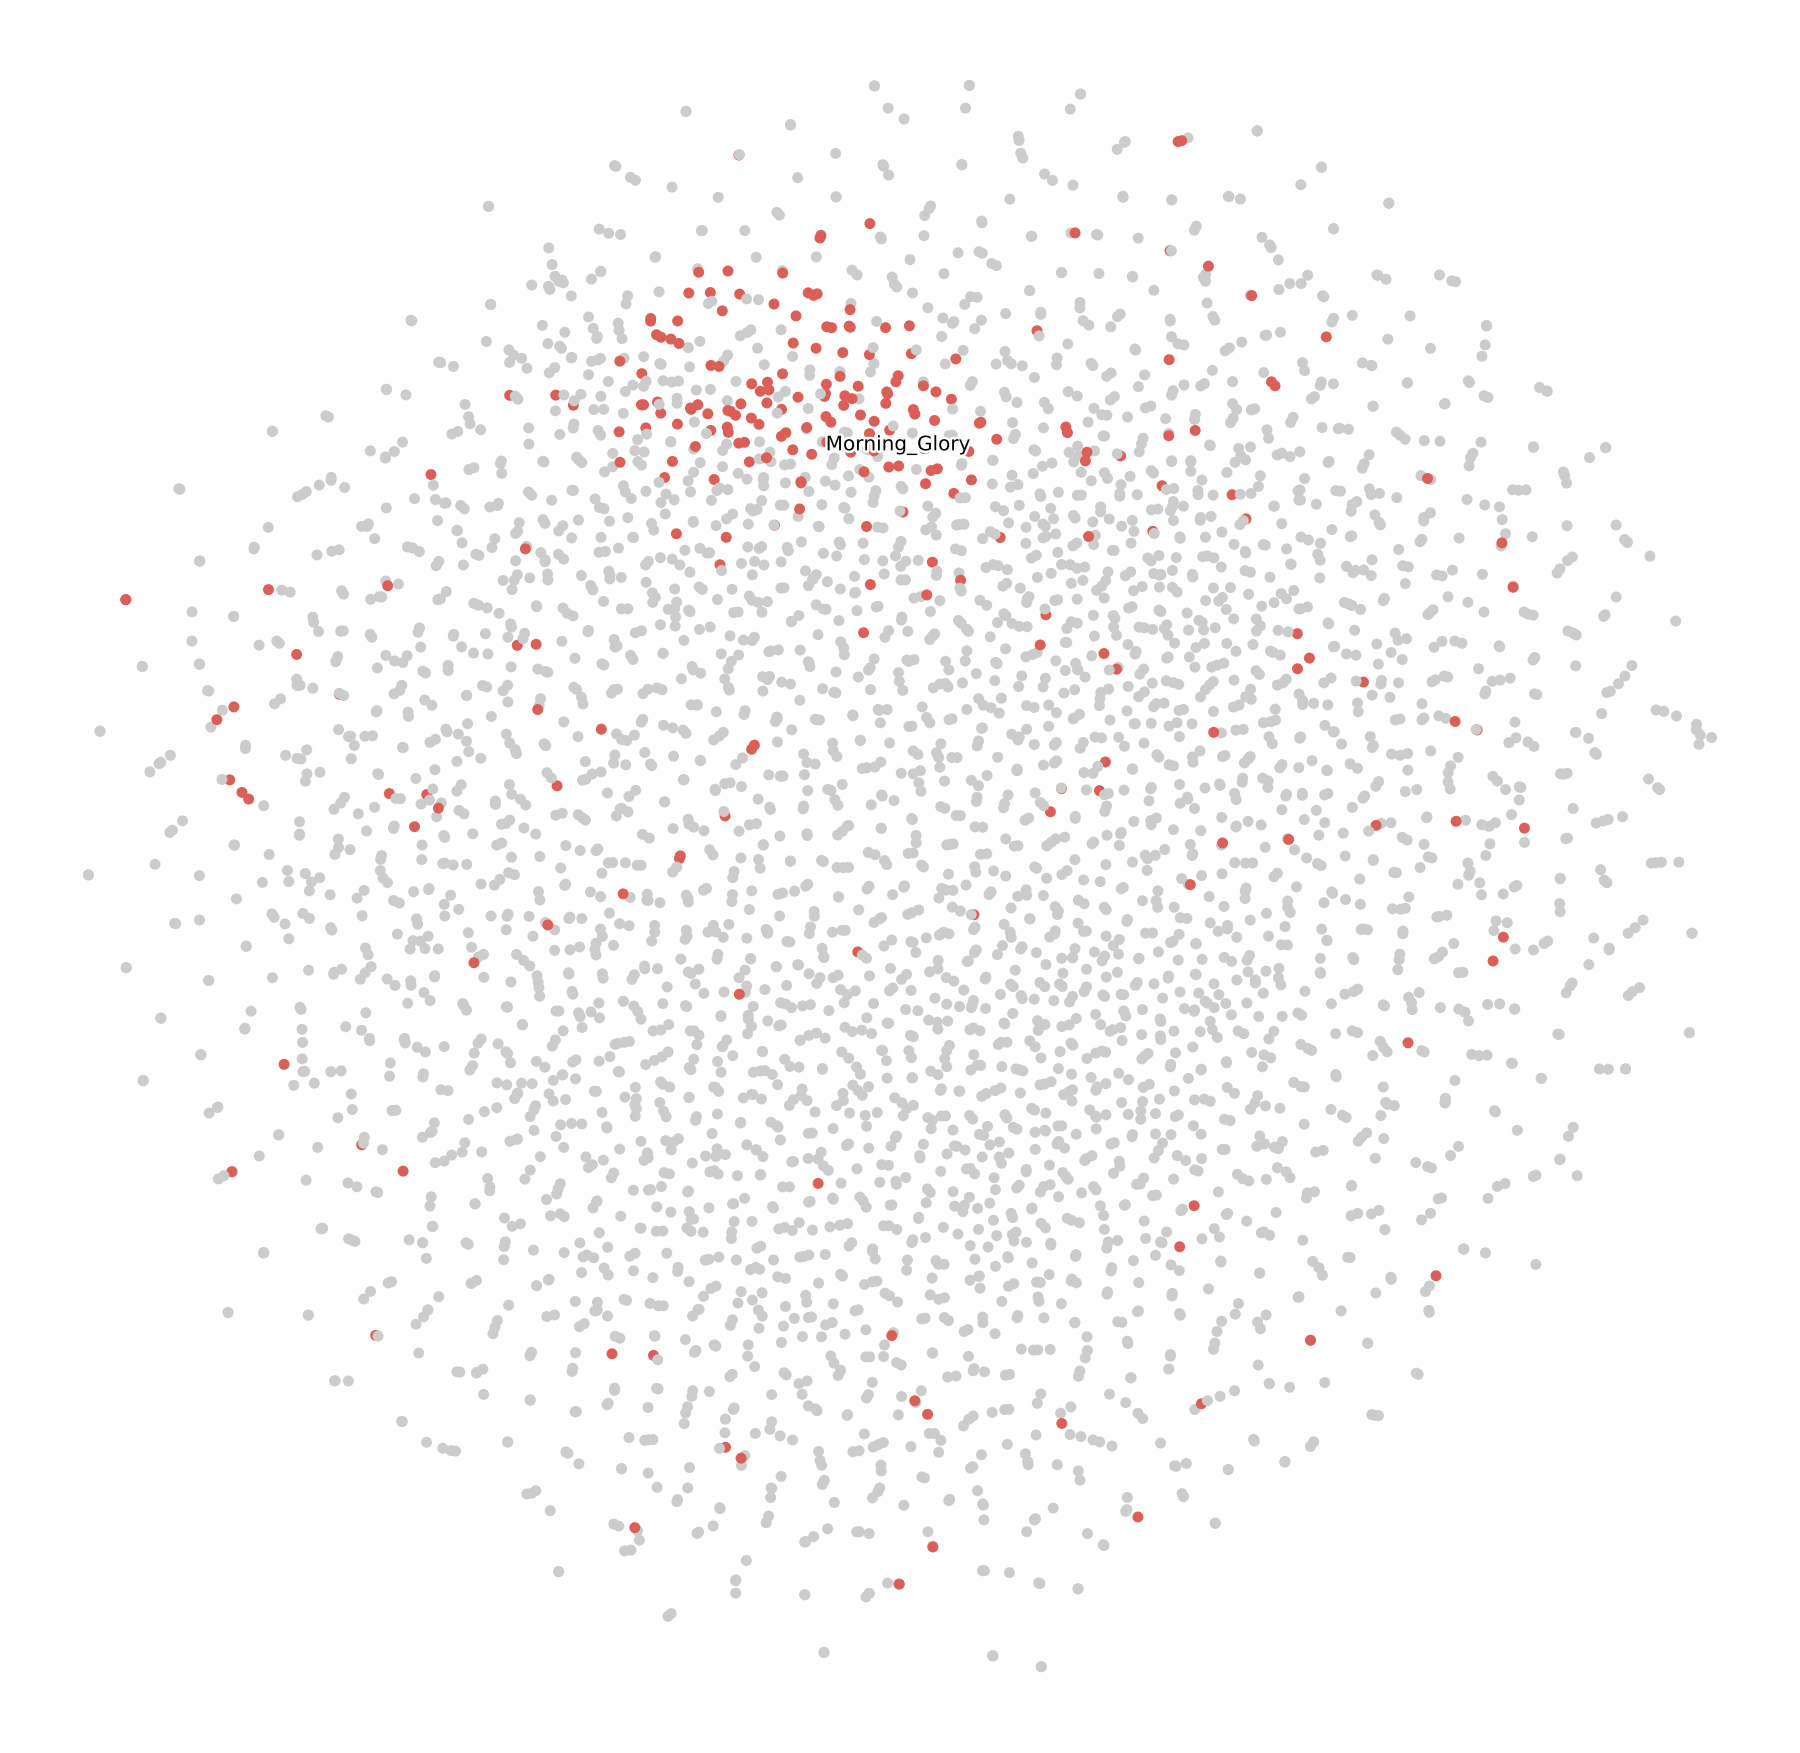

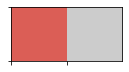

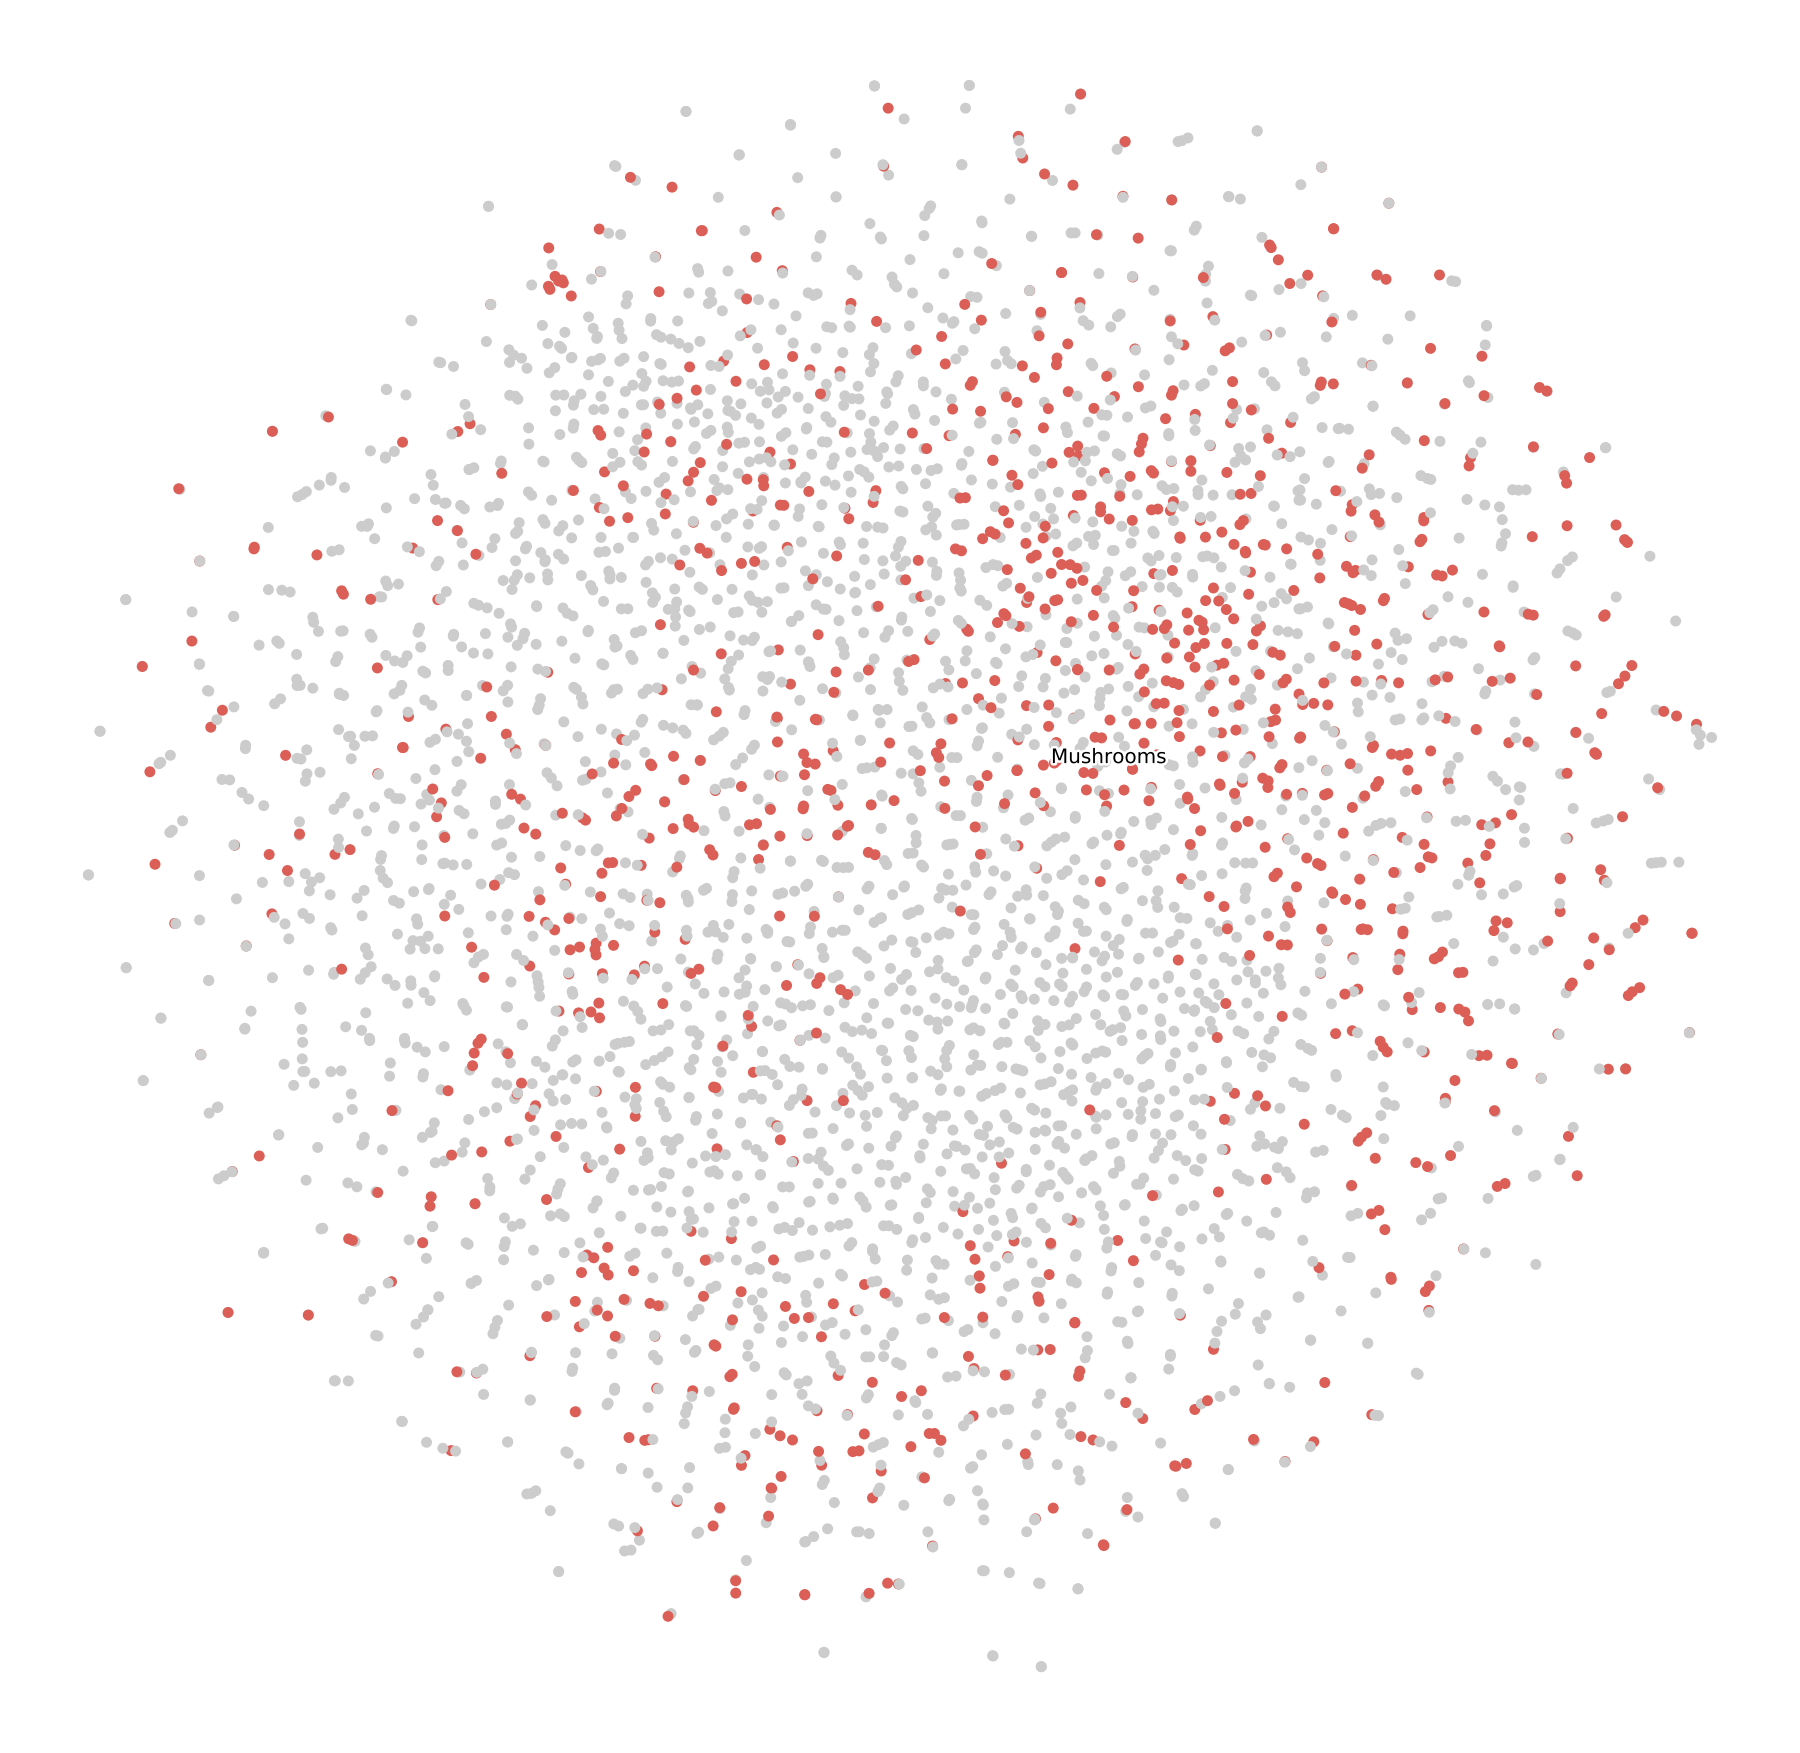

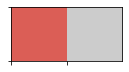

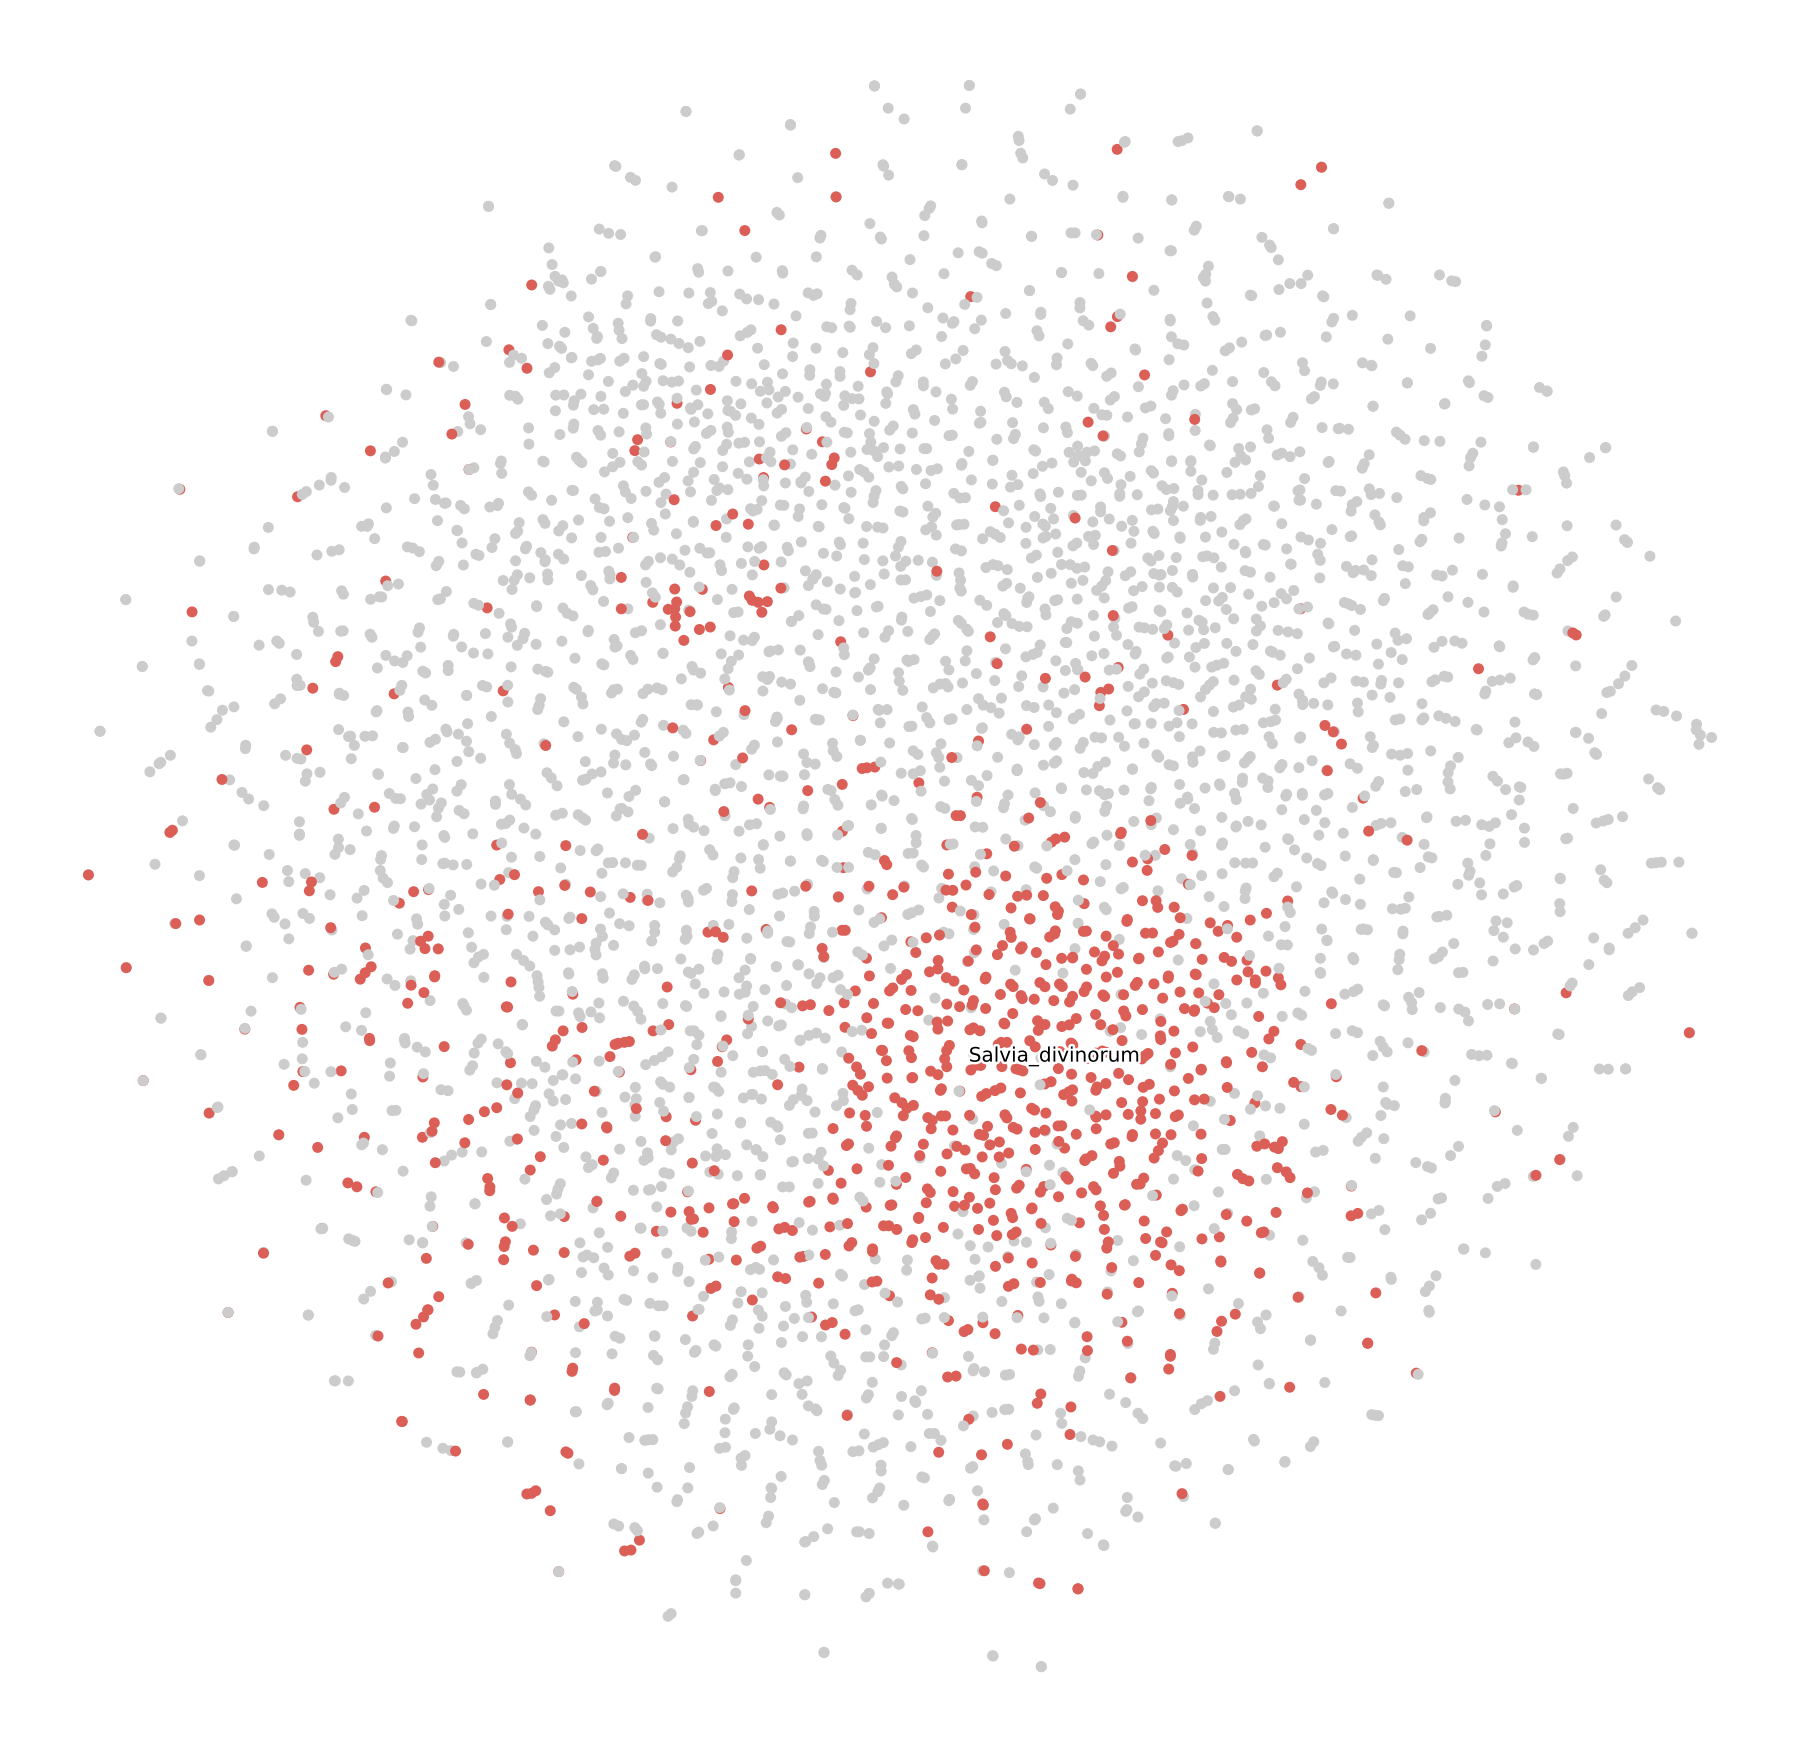

In [18]:
for drug in drugs:
    drugs_to_plot = [drug]
    scatter(X_projected, drugs_to_plot)
    

In [ ]:
# get average doc vec
avg_doc_vec = np.mean([model.docvecs[i] for i in range(len(model.docvecs))], axis=0)

# accumulate doc vecs for each drug in a dictionary
drug_to_doc_vecs_dict = collections.defaultdict(list)
for i, drug in enumerate(df["drug"]):
    doc_tag = f"DOC_{i}"
    doc_vec = model.docvecs[doc_tag]
    drug_to_doc_vecs_dict[drug].append(doc_vec)
    
# assign a psych vec for each psychedelic by taking adding the difference between the mean of the drug's doc vecs 
# and the average doc vec to the mean of the drug's doc vecs, in order to produce a vector that is more extreme in
# the ways that the drug's average doc vec is already extreme, so as to highlight what makes it distinct from the 
# other drug's average doc vec
SIGMA = 0
drug_to_psych_vec_dict = {drug : np.mean(doc_vecs, axis=0) + ((np.mean(doc_vecs, axis=0) - avg_doc_vec) * SIGMA) for drug, doc_vecs in drug_to_doc_vecs_dict.items()}

# print the words whose vectors are closest to each psych vec
for drug, psych_vec in drug_to_psych_vec_dict.items():
    print(drug+'\n', model.wv.most_similar([psych_vec]), '\n')
    